## References
http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf

In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np

from pygents.aigents_api import tokenize_re
from pygents.plot import plot_dict
from pygents.util import dictcount, dict_compress_with_loss, dictdict_div_dict, dictdict_mul_dictdict

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

In [2]:
test_dataset_file_path = "./data/corpora/English/distortions/sagarikashreevastava/test.csv"

In [3]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 


In [4]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


## Basic data check

### Binary Data Set (halilbabacan)

In [5]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)
df


,Text,N/A text,Label,N/A label
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


defaultdict(<class 'int'>, {'Distortion': 2594, 'No Distortion': 933, ' ': 0})


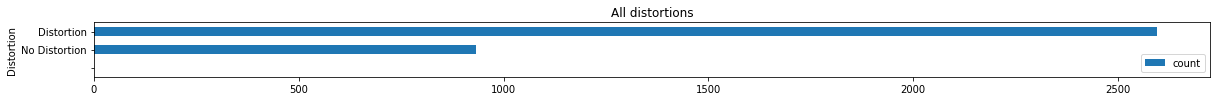

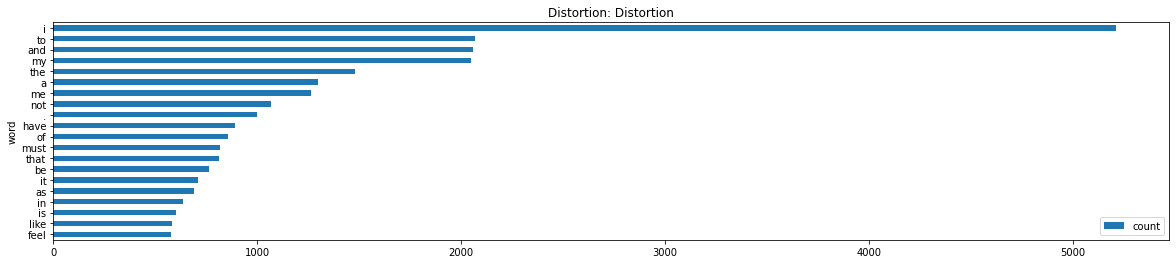

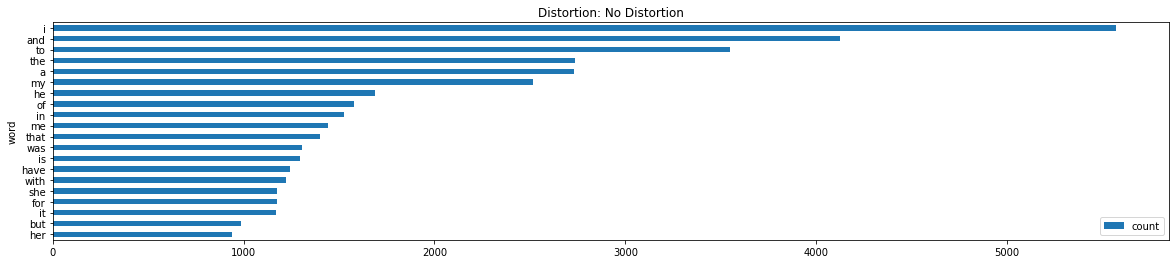

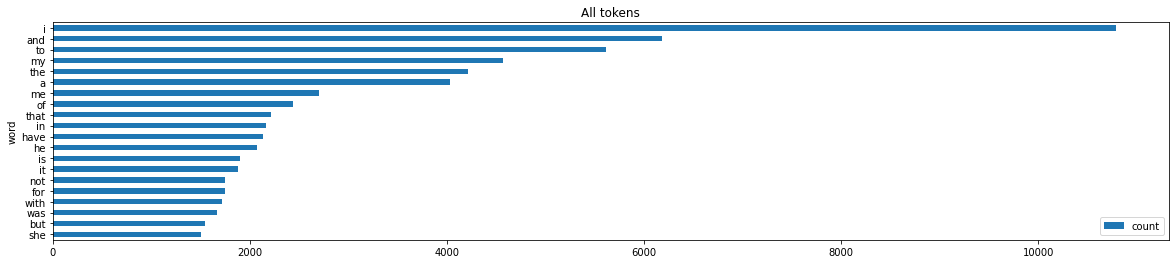

In [6]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = tokenize_re(text)

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
all_distortions[' '] = 0 # stub/hack
print(all_distortions)
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


### Multi-class Data Set (sagarikashreevastava)

In [7]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


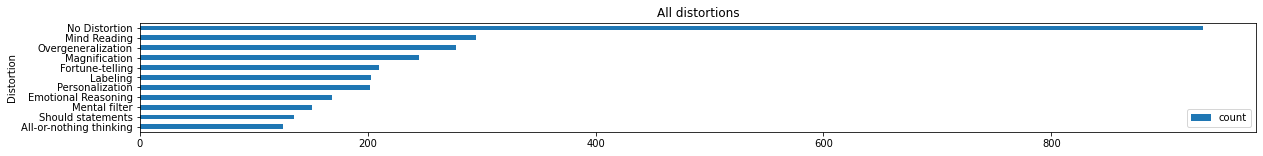

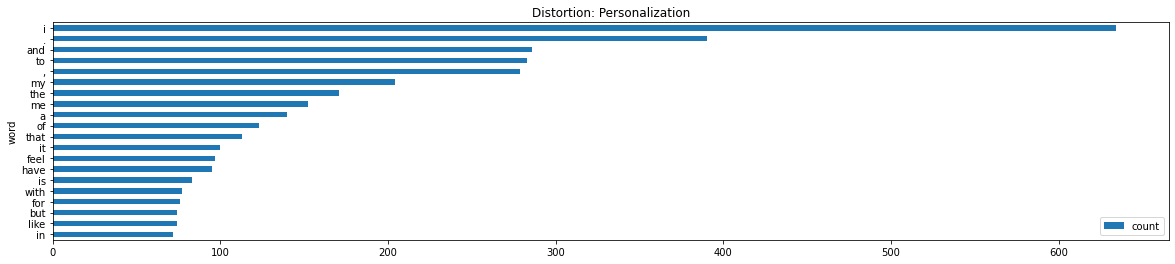

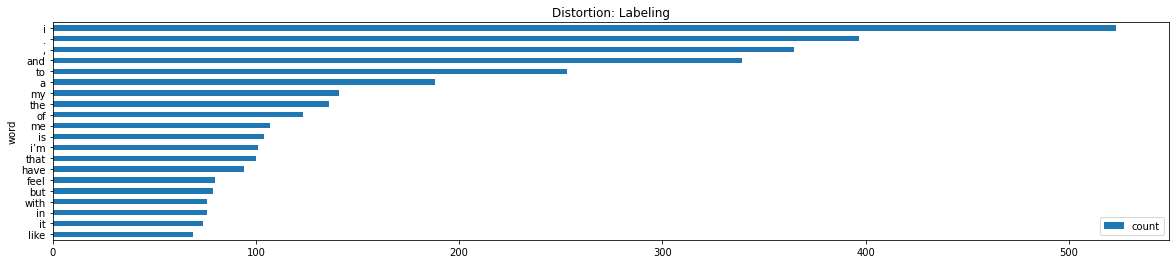

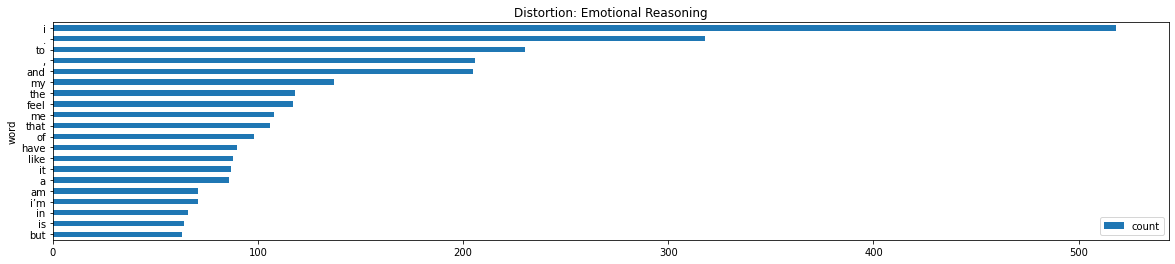

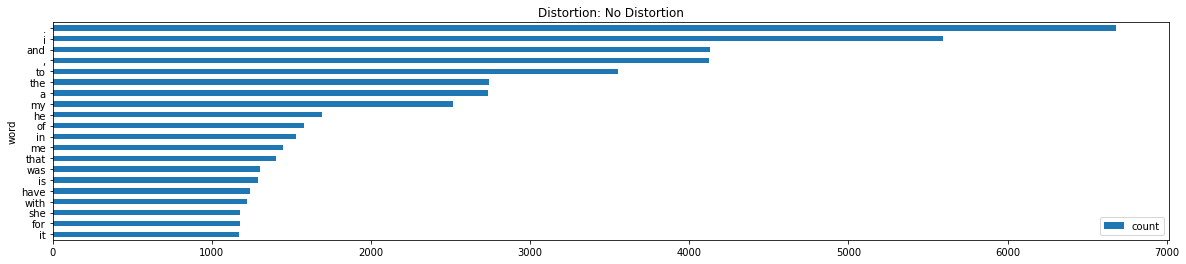

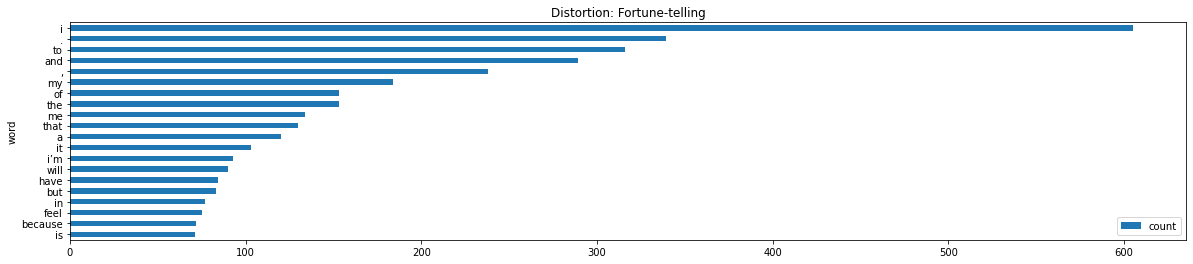

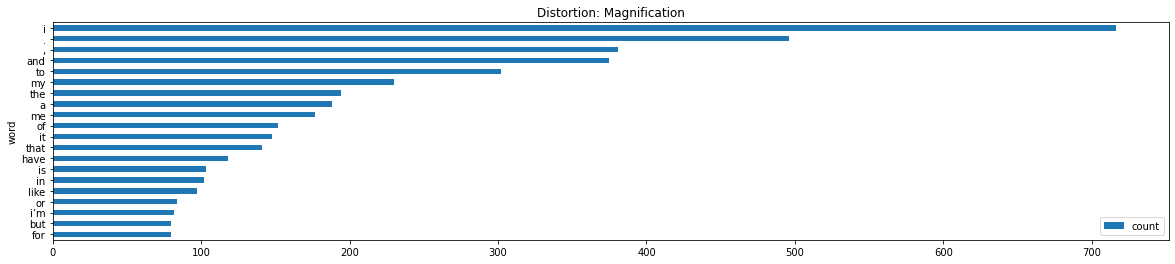

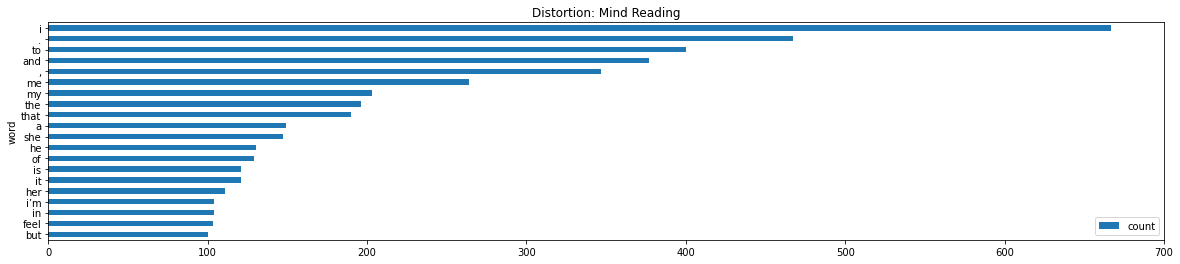

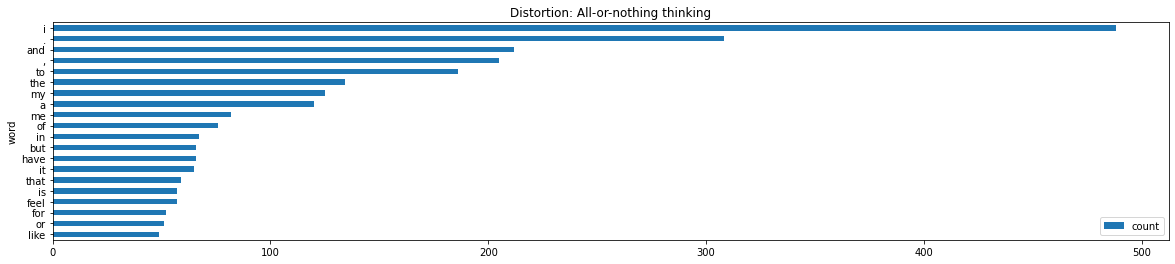

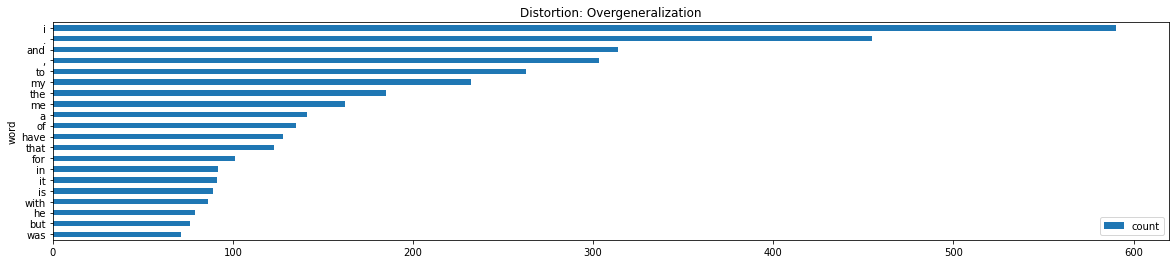

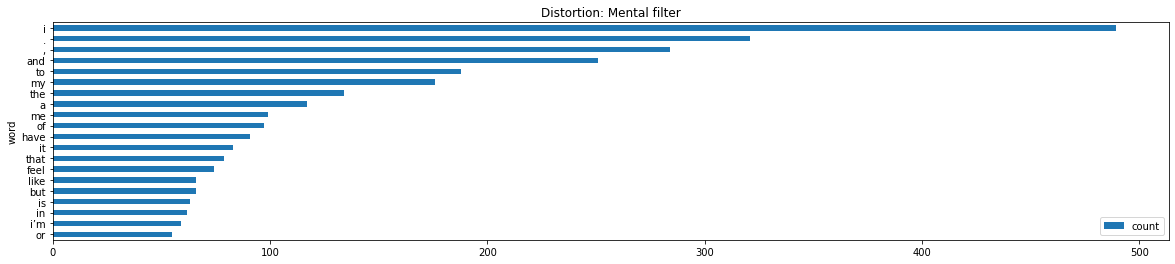

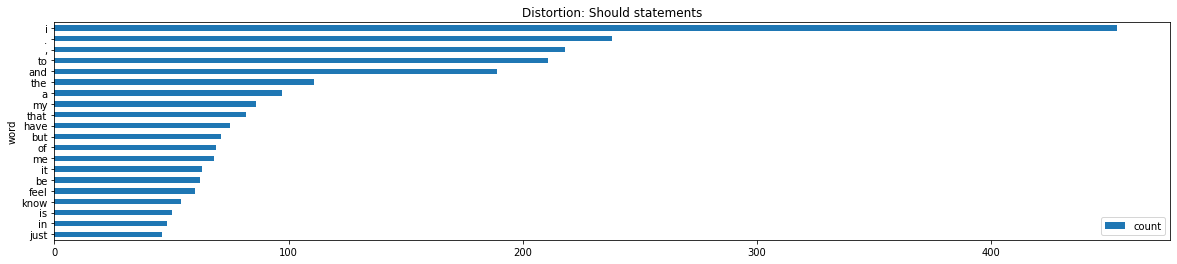

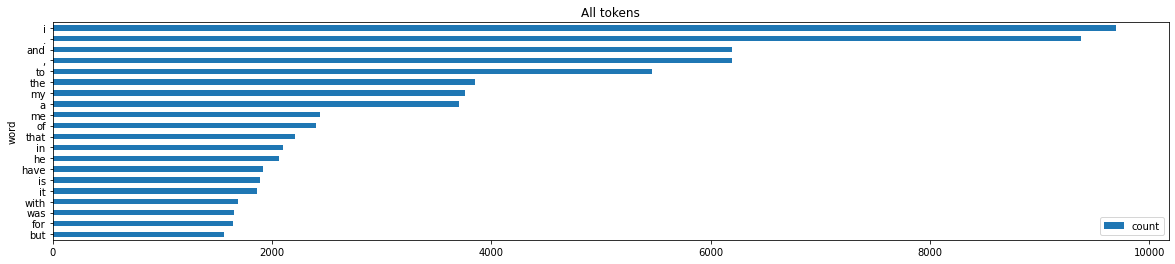

In [8]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = tokenize_re(text)

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


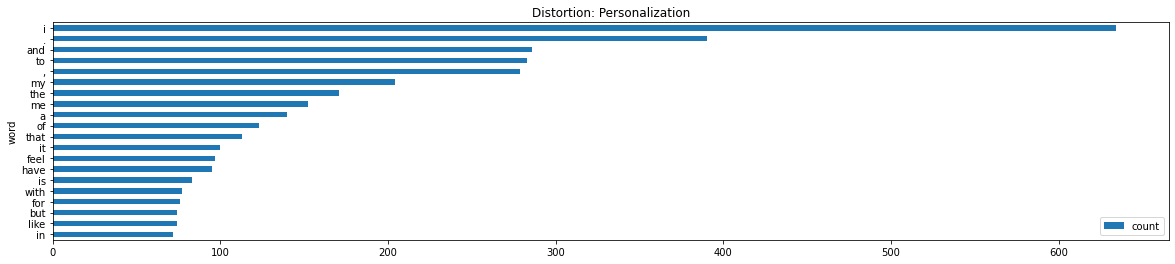

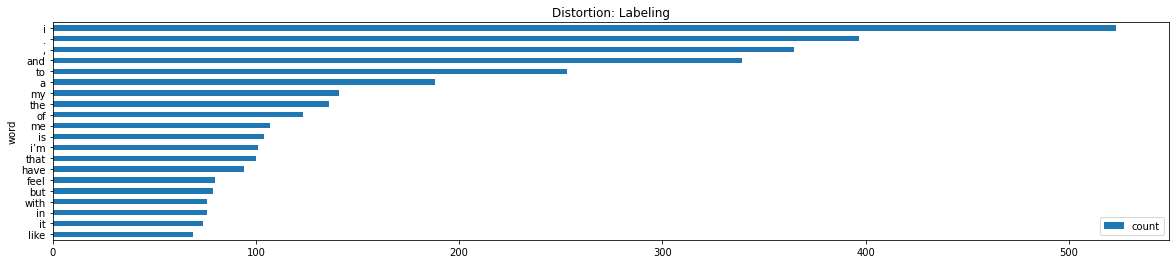

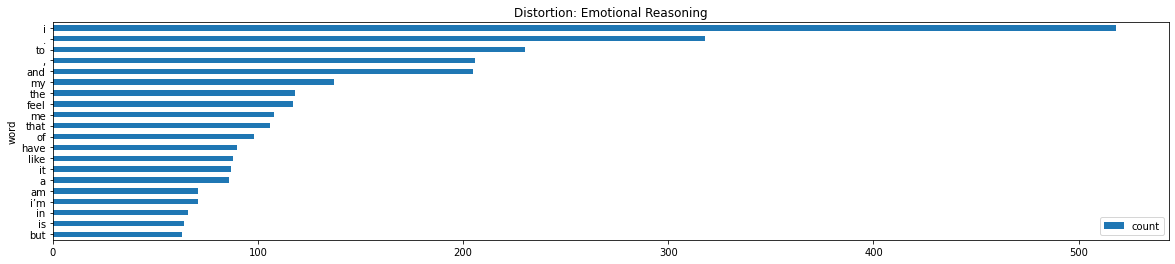

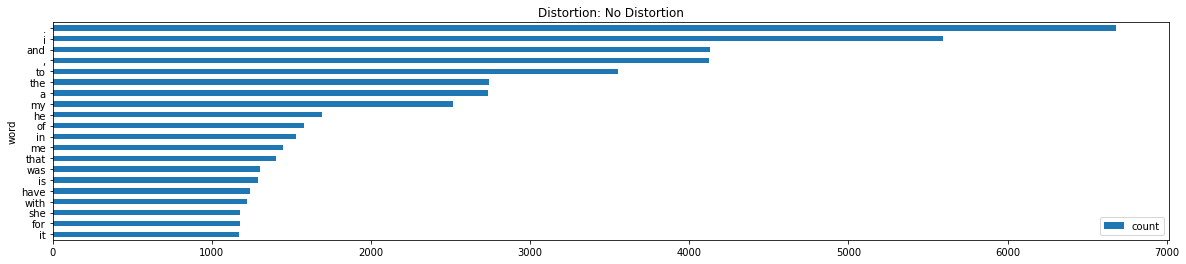

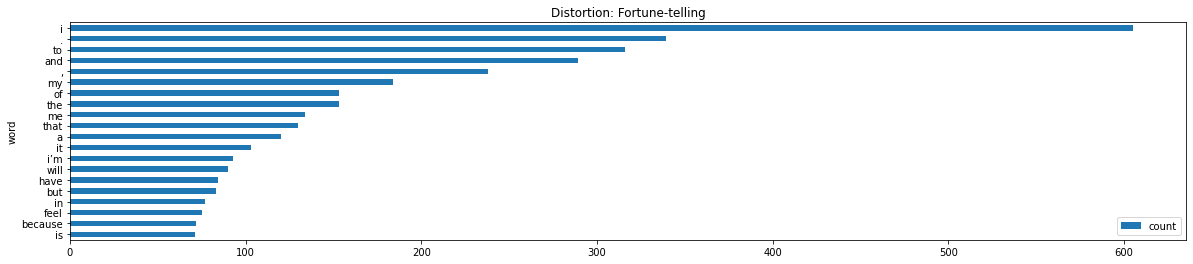

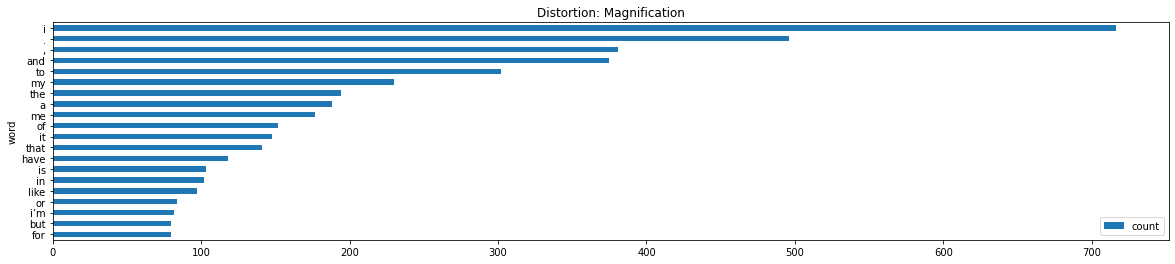

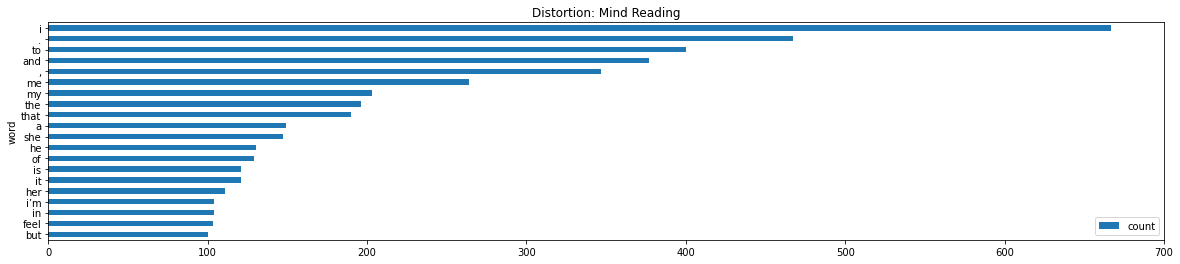

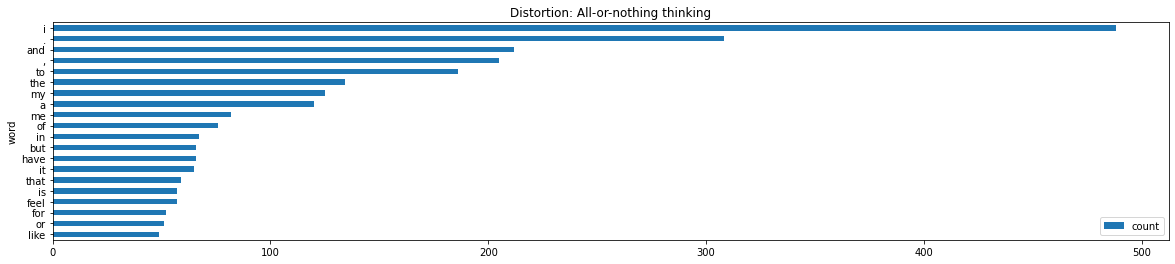

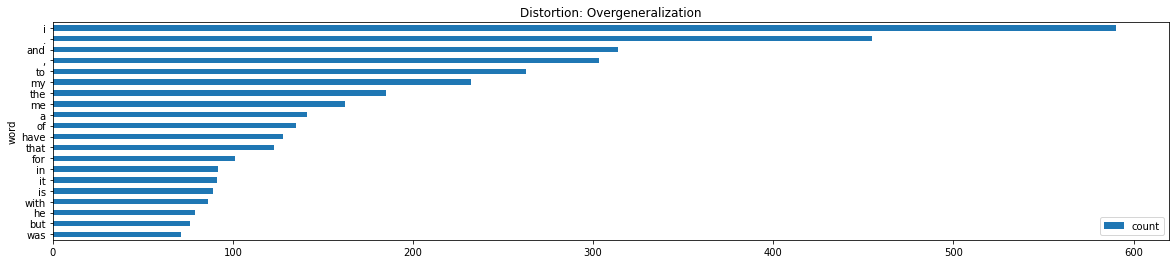

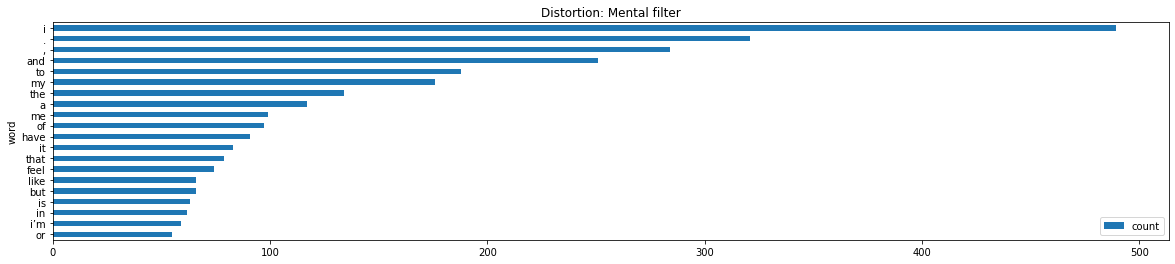

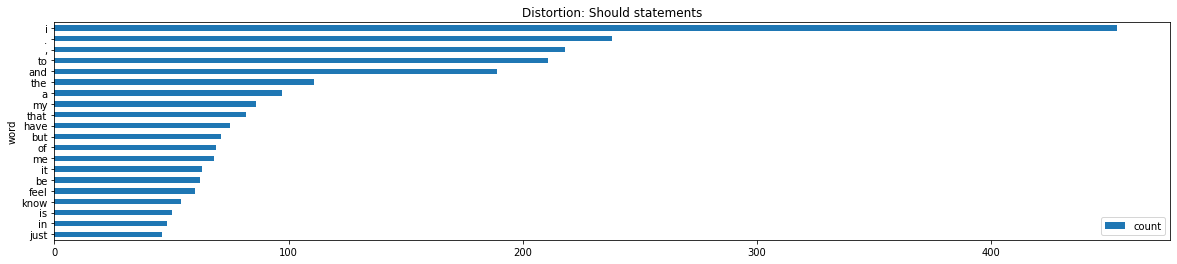

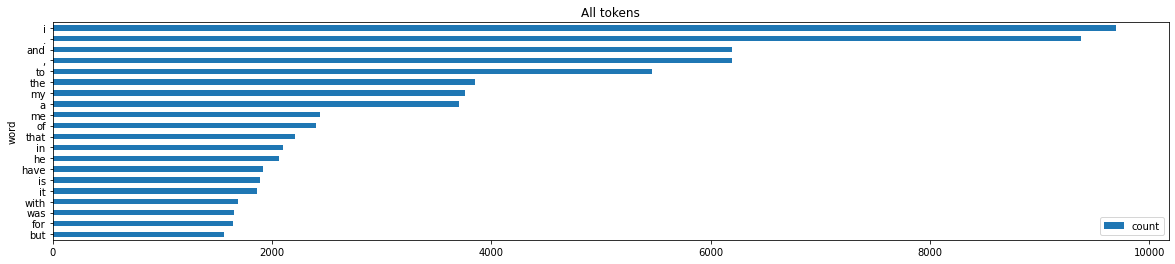

In [9]:
# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

## Define working functions to be moved to the code module

In [10]:
# Analyze the frequency of n-grams for each cognitive distortion

from pygents.aigents_api import build_ngrams

def count_ngrams_basic(df, n_max: int):

    distortions = defaultdict(int)

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    
    uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by Distortion
    uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
    n_gram_distortions = defaultdict(lambda: defaultdict(int)) # Counts of distortiions by N-gram

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present

        dictcount(distortions,primary_distortion)
        if secondary_distortion:
            dictcount(distortions,secondary_distortion)
        
        # Text tokenization
        tokens = tokenize_re(text)

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, n_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

            uniq_n_grams = set(n_grams)
            for uniq_n_gram in uniq_n_grams:
                dictcount(uniq_n_gram_dicts[primary_distortion], uniq_n_gram)
                dictcount(uniq_all_n_grams, uniq_n_gram)
                dictcount(n_gram_distortions[uniq_n_gram],primary_distortion)
                if secondary_distortion:
                    dictcount(uniq_n_gram_dicts[secondary_distortion], uniq_n_gram)
                    dictcount(n_gram_distortions[uniq_n_gram],secondary_distortion)
                
    # Normalizing distortion-specific counts by total counts
    norm_n_gram_dicts = {}
    for n_gram_dict in n_gram_dicts:
        norm_n_gram_dict = {}
        norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        dic = n_gram_dicts[n_gram_dict]
        for n_gram in dic:
            #print(dic[n_gram])
            #print(all_n_grams[n_gram])
            #break
            if len(n_gram) <= n_max:
                norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / all_n_grams[n_gram]

    # Normalize uniq counts 
    norm_uniq_n_gram_dicts = {}
    for uniq_n_gram_dict in uniq_n_gram_dicts:
        norm_uniq_n_gram_dict = {}
        norm_uniq_n_gram_dicts[uniq_n_gram_dict] = norm_uniq_n_gram_dict
        dic = uniq_n_gram_dicts[uniq_n_gram_dict]
        nonuniq_dic = n_gram_dicts[n_gram_dict]
        # Normalize uniq Document counts of N-grams by distortion by Documents count by Distortion
        for n_gram in dic:
            if len(n_gram) <= n_max:
                #norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) * nonuniq_dic[n_gram] / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram]) / all_n_grams[n_gram]
                norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram])
 
    n_gram_distortions_counts = {}
    for n_gram, dist_dict in n_gram_distortions.items():
        n_gram_distortions_counts[n_gram] = len(dist_dict)
    n_gram_distortions_counts

    return distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, norm_uniq_n_gram_dicts, n_gram_distortions_counts
                

## Definitions
|Python|Python meaning|Formula|Formula meaning|
|---|---|---|---|
|distortions | counts of texts with particular distortion | $D_d$ | count of texts with distortion $d$ per corpus|
|n_gram_dicts | counts of N-grams per distortion | $GD_{gd}$ | count of N-gram $g$ associations with distortion $d$ - **frequency**|
|all_n_grams | counts of N-grams per corpus | $G_g$ | total count of N-gram $g$ in the entire corpus|
|norm_n_gram_dicts | counts of N-grams normalized by corpus counts | $\bar{GD}_{gd} = GD_{gd} / G_g$ | **normalized frequency** |
|uniq_n_gram_dicts | uniq counts of N-grams by distortion | $GD^u_{gd}$ | count of unique N-gram $g$ associations with distortion $d$ (counting every N-gram appearing in particular text only once)|
|uniq_all_n_grams | uniq counts of N-grams per corpus | $G^u_g$ | total uniq count of N-gram $g$ in the entire corpus (counting every N-gram appearing in particular text only once)|
|n_gram_distortions | counts of distortions by N-gram | $DG_{dg}$ | count of distortion $d$ associations with N-gram $g$ (counting every N-gram appearing in particular text only once), $DG_{dg} == GD^u_{gd}$ |
|norm_uniq_n_gram_dicts | counts of uniq N-grams normalized by uniq corpus counts | $\bar{GD}^u_{gd} = GD^u_{gd} / G^u_g$ | **normalized uniq frequency** |
|n_gram_distortions_counts | counts of distortions by N-gram| $D_g$ | count of distortions by N-gram $g$, based on $DG_{dg}$ |

In [12]:
def plot_debug_charts(distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, n_top):
    # Display graphs for all distortions
    if len(distortions) < 3: #stub/fix/hack
           distortions[' '] = 0
    plot_dict(
            distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=n_top             # All
        )
    # Display graphs for each distortion
    plot_dict(
            all_n_grams,
            labels="word",
            values="count",
            title=f"All",
            head=n_top             # All
        )
    for distortion, ngram_dict in n_gram_dicts.items():
        plot_dict(
            ngram_dict,
            labels="word",
            values="count",
            title=f"Distortion: {distortion}",
            head=n_top             # Top 20 n-grams
        )
    # Display graphs for each distortion
    for distortion, ngram_dict in norm_n_gram_dicts.items():
        plot_dict(
            ngram_dict,
            labels="word",
            values="count",
            title=f"Normalized Distortion: {distortion}",
            head=n_top             # Top 20 n-grams
        )
    

## Test on synthetic data

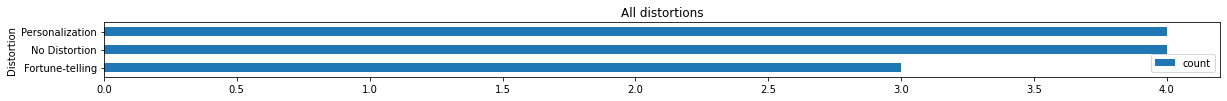

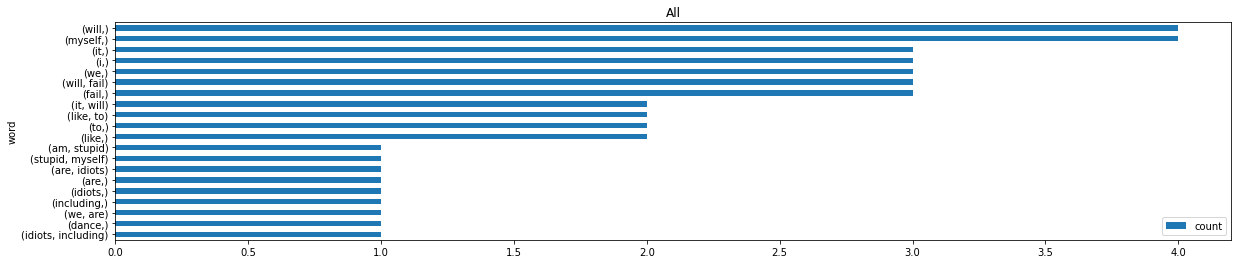

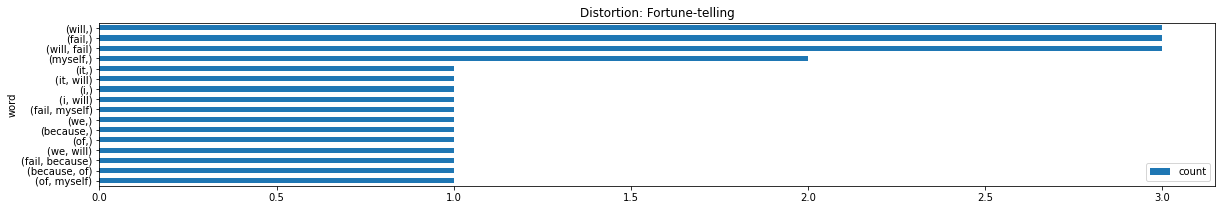

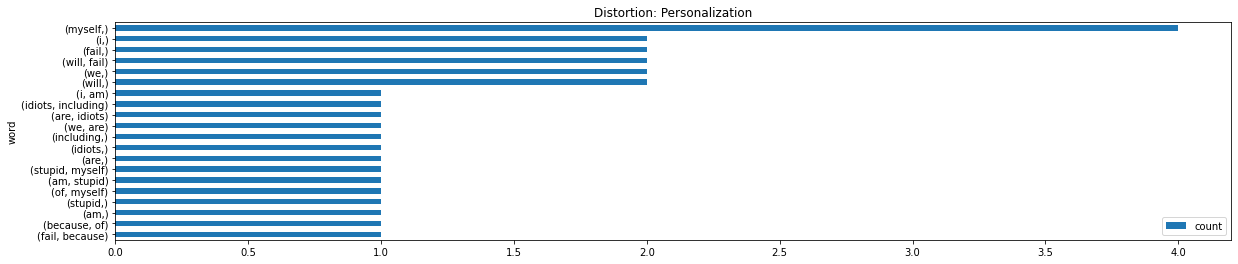

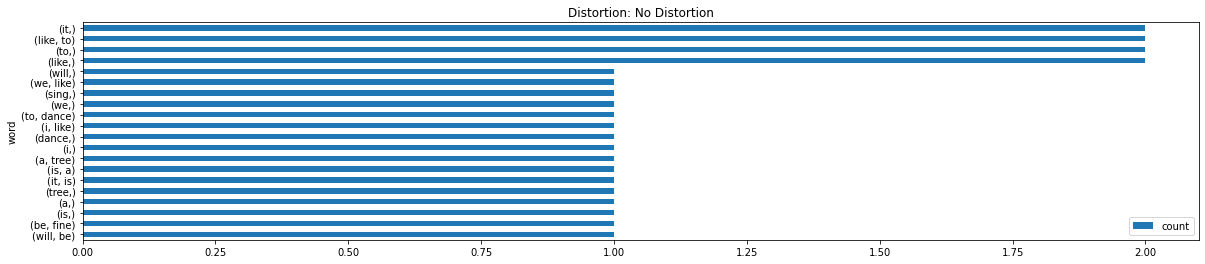

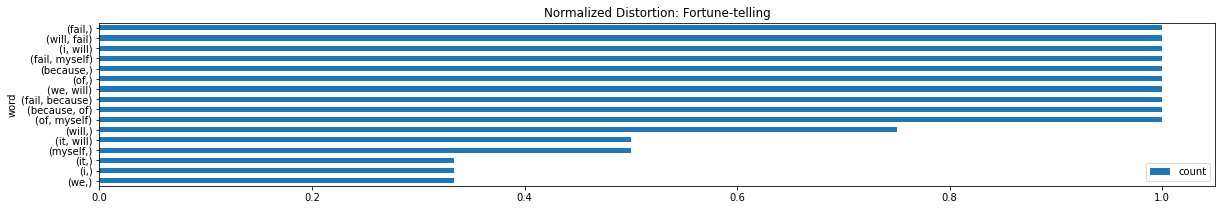

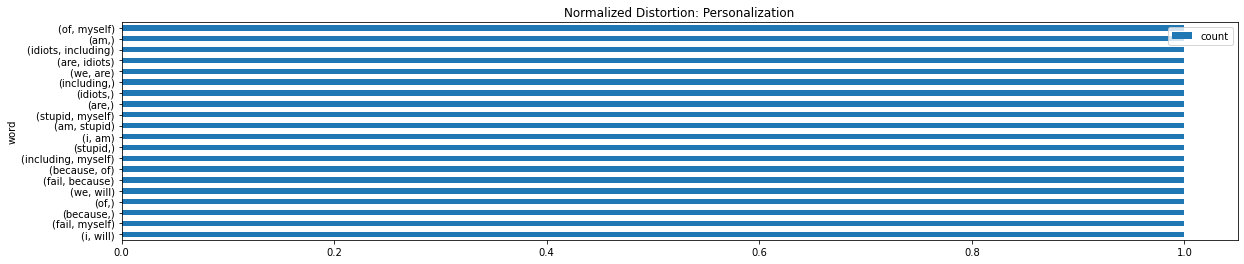

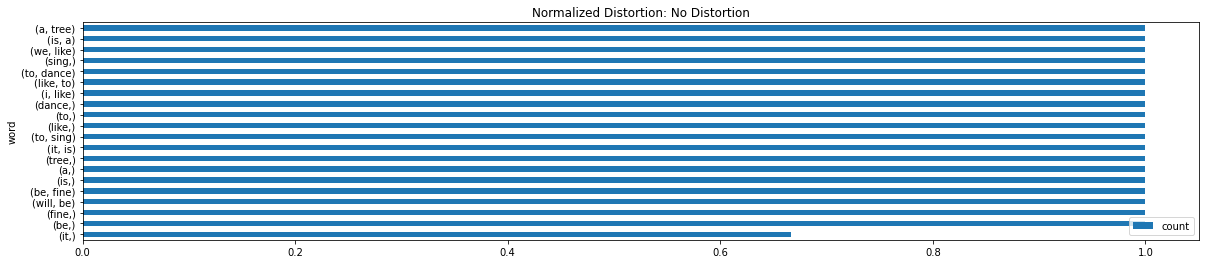

In [13]:
df = pd.read_csv(test_dataset_file_path)
df = df.drop('Id_Number', axis=1) # delete columnb with id 
    
distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts \
= count_ngrams_basic(df,2)

plot_debug_charts(distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, 20)


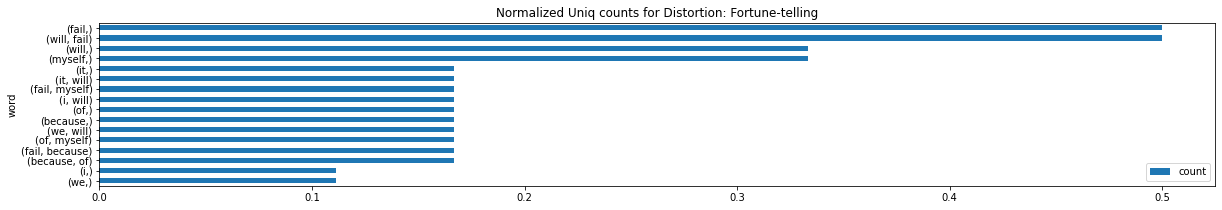

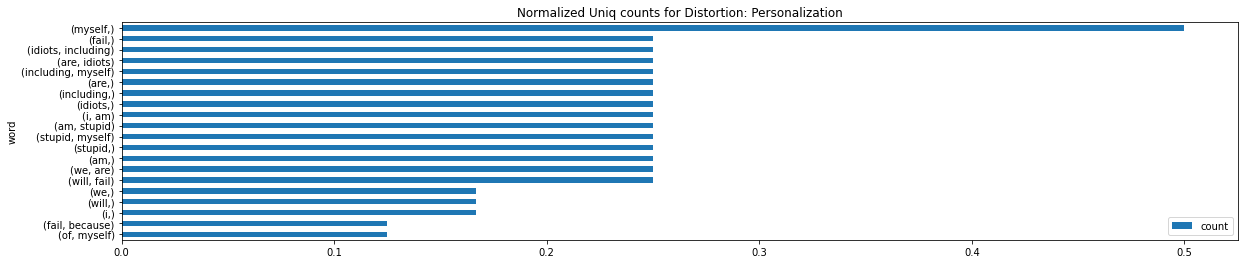

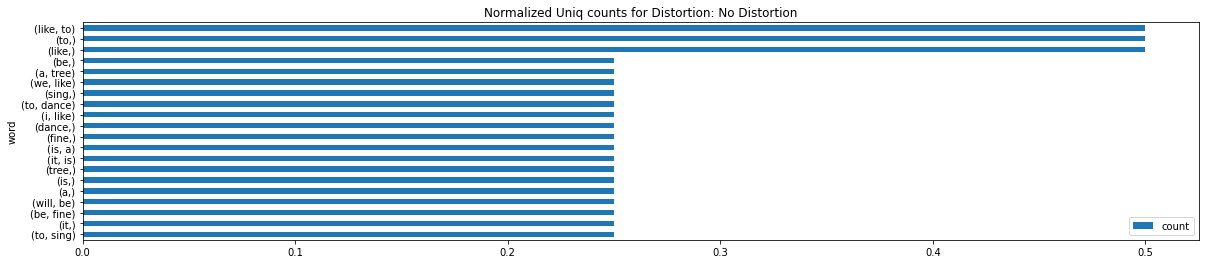

In [14]:
   for distortion, ngram_dict in norm_uniq_n_gram_dicts.items():
        plot_dict(
            ngram_dict,
            labels="word",
            values="count",
            title=f"Normalized Uniq counts for Distortion: {distortion}",
            head=20             # Top 20 n-grams
        )

## Test on Binary Data

In [15]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)

distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts \
= count_ngrams_basic(df,3)
#plot_debug_charts(distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, 50)


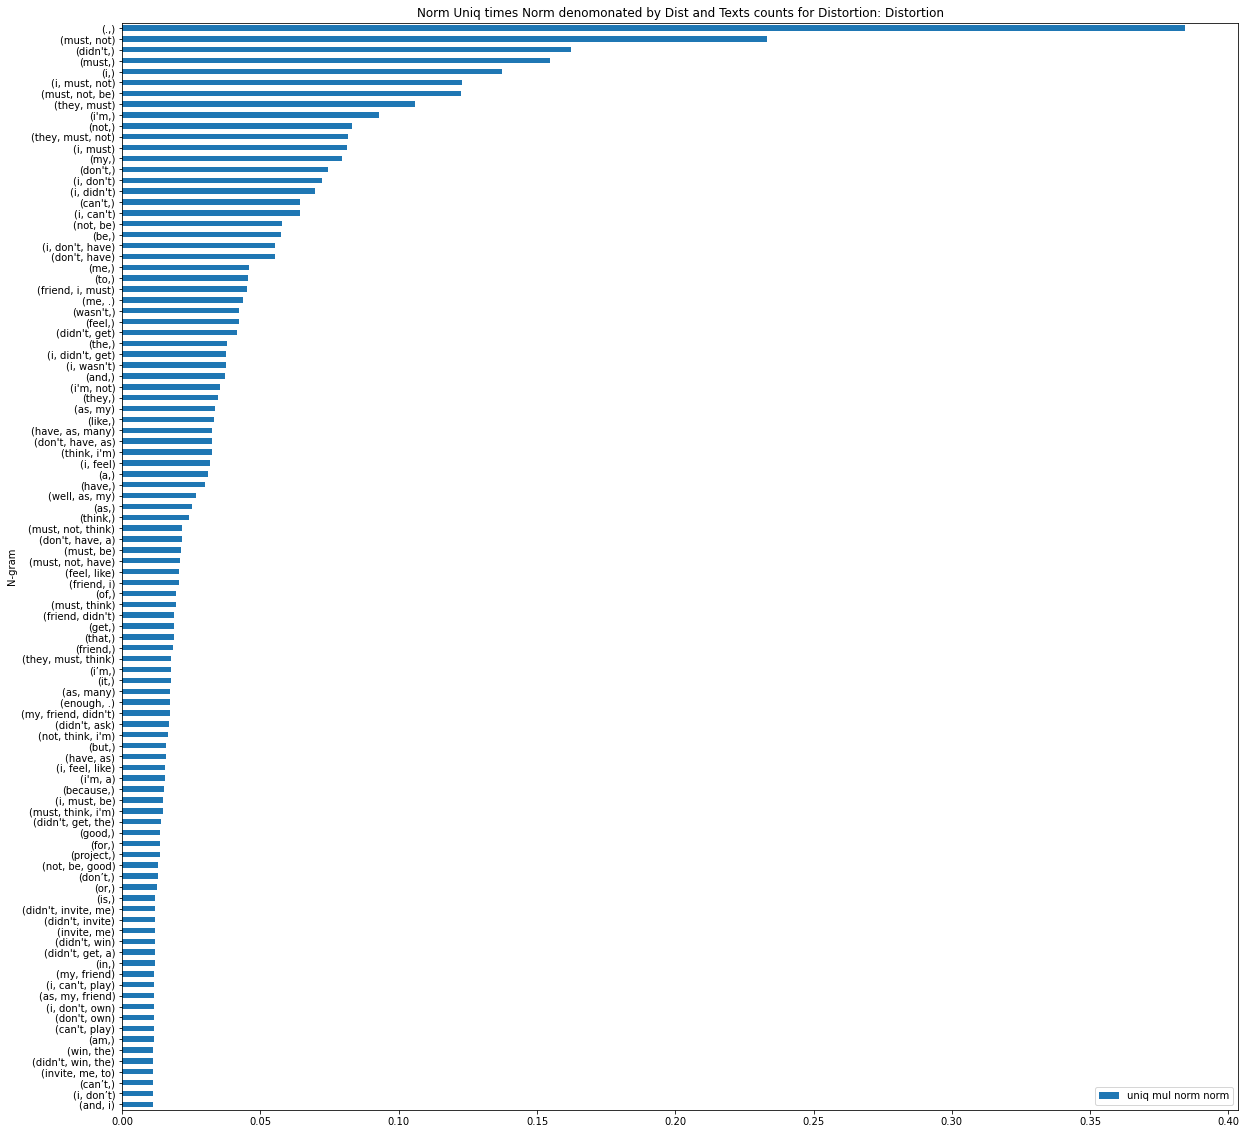

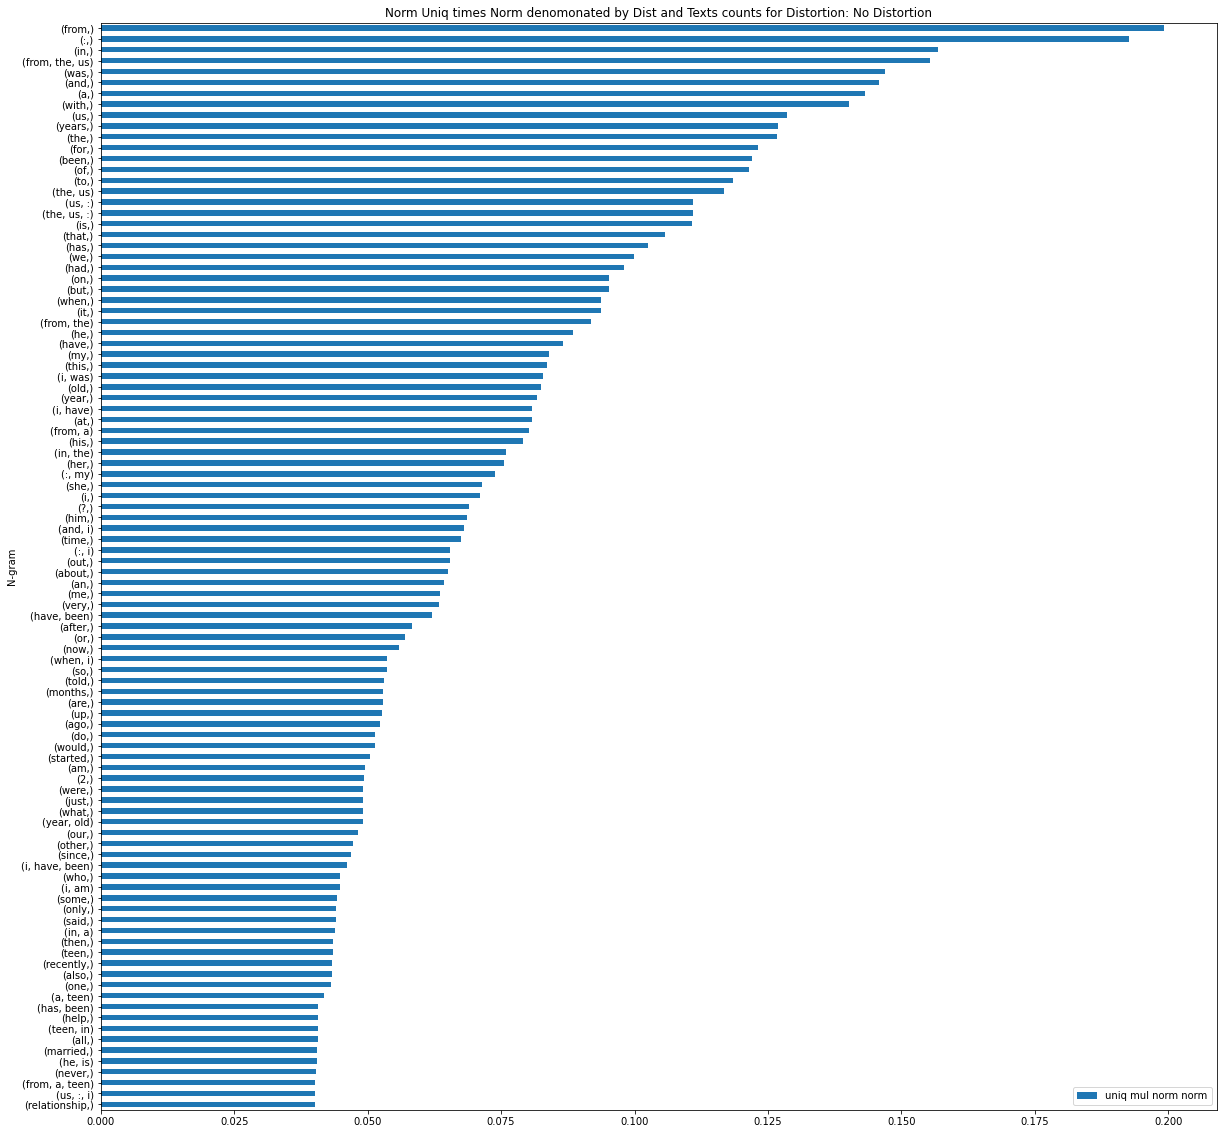

In [16]:
norm = dictdict_div_dict(n_gram_dicts,all_n_grams)
norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)
norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)
norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)

norm_norm_uniq_norm_norm = {} # looks like desired magic
for dist in distortions:
    if not dist in norm_norm_uniq_norm: #hack
        continue
    dic = norm_norm_uniq_norm[dist]
    norm_norm_uniq_norm_norm[dist] = {}
    for n_gram in dic:
        norm_norm_uniq_norm_norm[dist][n_gram] = dic[n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]
"""
for distortion, ngram_dict in norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="norm",head=50,title=f"Norm counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq norm",head=50,title=f"Norm Uniq counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm",head=50,title=f"Norm Uniq times Norm counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_norm_uniq_norm.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm norm",head=100,title=f"Norm Uniq times Norm counts by Dist counts for Distortion: {distortion}")
"""
for distortion, ngram_dict in norm_norm_uniq_norm_norm.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm norm",head=100,title=f"Norm Uniq times Norm denomonated by Dist and Texts counts for Distortion: {distortion}")


In [17]:
print('N-grams:',len(uniq_all_n_grams))
print('No threshold',len(n_gram_dicts['Distortion']))
for t in [0.9,0.7,0.5,0.3,0.1]:
    d = dict_compress_with_loss(norm_norm_uniq_norm,t)
    print(t,len(d['Distortion']))

print()

for n_gram in [('.',),('didn\'t',),('must',),('i',),('i\'m',),('from',),(':',)]:
    print(n_gram)
    print(n_gram_dicts['Distortion'][n_gram])
    print(n_gram_dicts['No Distortion'][n_gram])
    print(all_n_grams[n_gram])
    print(uniq_n_gram_dicts['Distortion'][n_gram])
    print(uniq_n_gram_dicts['No Distortion'][n_gram])
    print(uniq_all_n_grams[n_gram])


N-grams: 220803
No threshold 87843
0.9 66359
0.7 66359
0.5 66359
0.3 66359
0.1 66359

('.',)
998
0
998
997
0
997
("didn't",)
421
0
421
421
0
421
('must',)
816
7
823
815
6
821
('i',)
5214
5568
10782
2087
871
2958
("i'm",)
251
0
251
241
0
241
('from',)
161
769
930
147
566
713
(':',)
17
404
421
15
389
404


## Test on Multi-Class Data 

In [18]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df

distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts \
= count_ngrams_basic(df,3)
#plot_debug_charts(distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, 20)


In [25]:
n_gram_distortions

defaultdict(<function __main__.count_ngrams_basic.<locals>.<lambda>()>,
            {('very',): defaultdict(int,
                         {'Personalization': 19,
                          'No Distortion': 266,
                          'Overgeneralization': 23,
                          'Mental filter': 15,
                          'Emotional Reasoning': 16,
                          'Labeling': 33,
                          'Should statements': 12,
                          'All-or-nothing thinking': 11,
                          'Mind Reading': 27,
                          'Fortune-telling': 12,
                          'Magnification': 30}),
             ('my',): defaultdict(int,
                         {'Personalization': 118,
                          'Labeling': 85,
                          'Emotional Reasoning': 85,
                          'No Distortion': 795,
                          'Fortune-telling': 110,
                          'Magnification': 140,
              

In [26]:
n_gram_distortions_counts

{('very',): 11,
 ('my',): 11,
 ('on',): 11,
 ('duty',): 3,
 ('has',): 11,
 ('knows',): 8,
 ('about',): 11,
 ('with',): 11,
 ('it',): 11,
 ('she',): 11,
 ('voice',): 8,
 ('hope',): 9,
 ('someone',): 11,
 ('do',): 11,
 ('im',): 11,
 ('while',): 11,
 ('are',): 11,
 ('always',): 11,
 ('to',): 11,
 ('.',): 11,
 ('concerned',): 10,
 ('active',): 3,
 ('nothing',): 11,
 ('pregnancy',): 4,
 ('the',): 11,
 ('this',): 11,
 ('fimilar',): 1,
 ('and',): 11,
 ('with', 'my'): 11,
 ('on', 'active'): 1,
 ('are', 'always'): 4,
 ('about', 'this'): 10,
 ('it', 'has'): 9,
 ('voice', 'are'): 1,
 ('im', 'very'): 3,
 ('has', 'nothing'): 2,
 ('fimilar', 'someone'): 1,
 ('pregnancy', 'while'): 1,
 ('concerned', 'about'): 5,
 ('while', 'on'): 2,
 ('do', 'with'): 9,
 ('and', 'hope'): 2,
 ('someone', 'she'): 2,
 ('she', 'knows'): 4,
 ('very', 'concerned'): 3,
 ('always', 'fimilar'): 1,
 ('nothing', 'to'): 5,
 ('knows', 'im'): 3,
 ('this', 'and'): 7,
 ('my', 'pregnancy'): 1,
 ('active', 'duty'): 2,
 ('duty', '.'): 1

' \nfor distortion, ngram_dict in uniq_n_gram_dicts.items():\n        plot_dict(\n            ngram_dict,\n            labels="word",\n            values="count",\n            title=f"Raw Uniq counts for Distortion: {distortion}",\n            head=20             # Top 20 n-grams\n        )\n\nfor distortion, ngram_dict in norm_uniq_n_gram_dicts.items():\n        plot_dict(\n            ngram_dict,\n            labels="word",\n            values="count",\n            title=f"Normalized Uniq counts for Distortion: {distortion}",\n            head=20             # Top 20 n-grams\n        )\n'

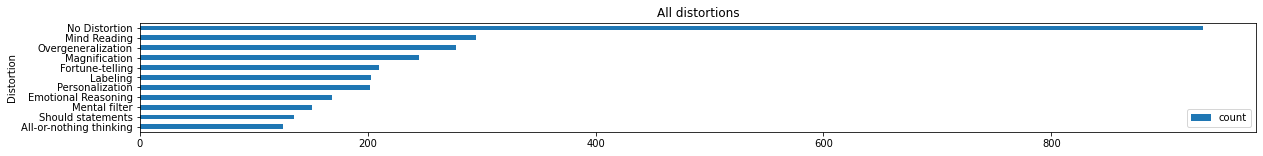

In [19]:
# Display graphs for all distortions
plot_dict(
            distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
        )
""" 
for distortion, ngram_dict in uniq_n_gram_dicts.items():
        plot_dict(
            ngram_dict,
            labels="word",
            values="count",
            title=f"Raw Uniq counts for Distortion: {distortion}",
            head=20             # Top 20 n-grams
        )

for distortion, ngram_dict in norm_uniq_n_gram_dicts.items():
        plot_dict(
            ngram_dict,
            labels="word",
            values="count",
            title=f"Normalized Uniq counts for Distortion: {distortion}",
            head=20             # Top 20 n-grams
        )
"""

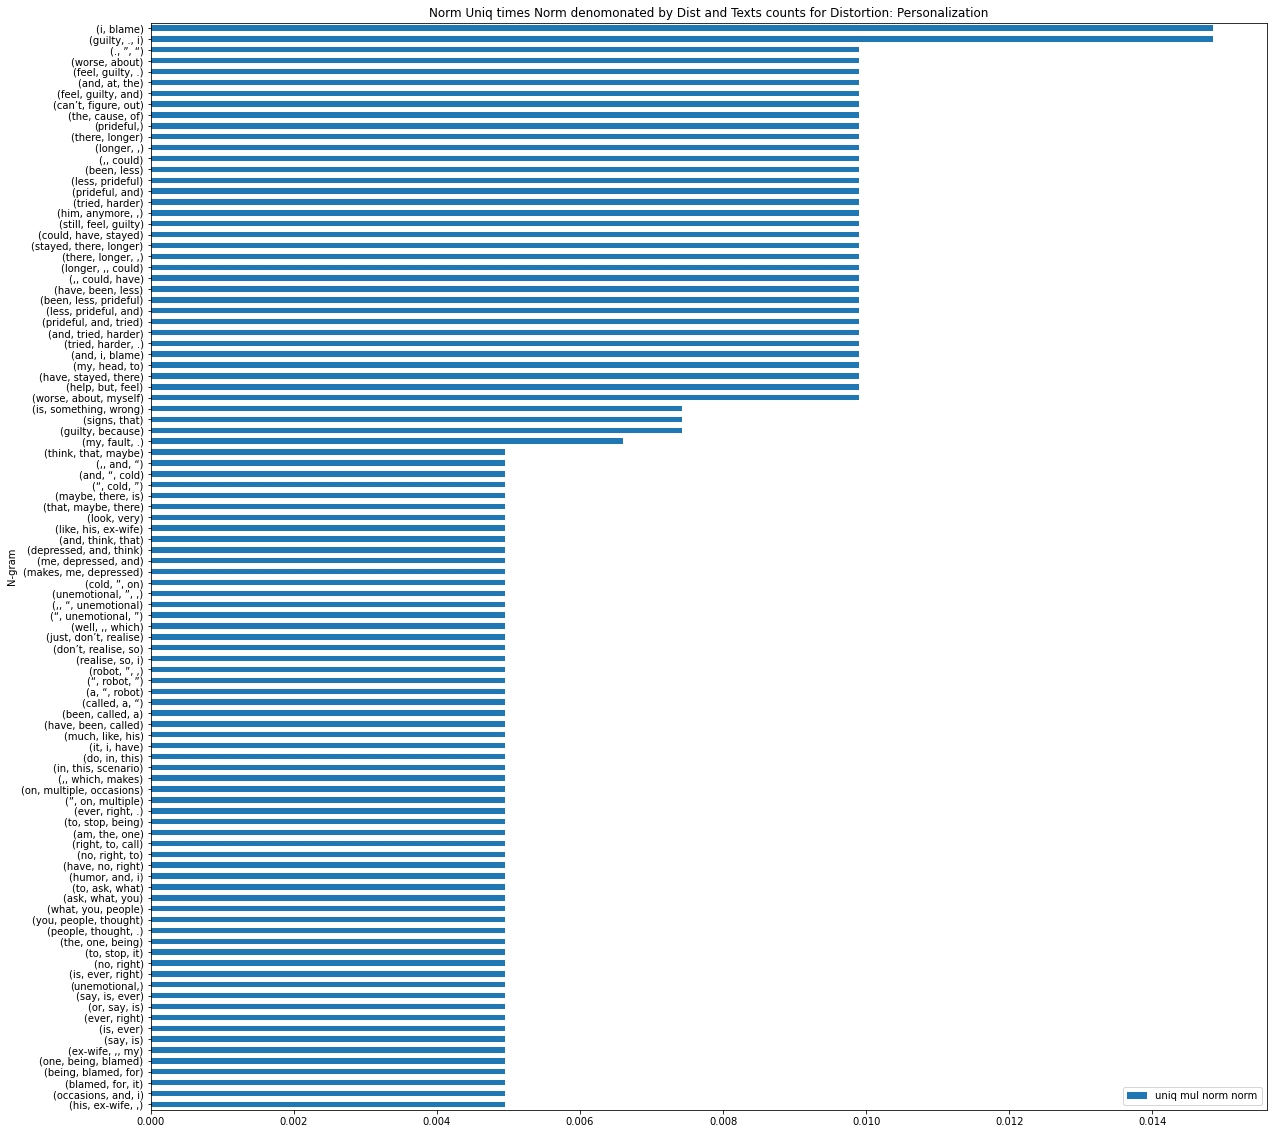

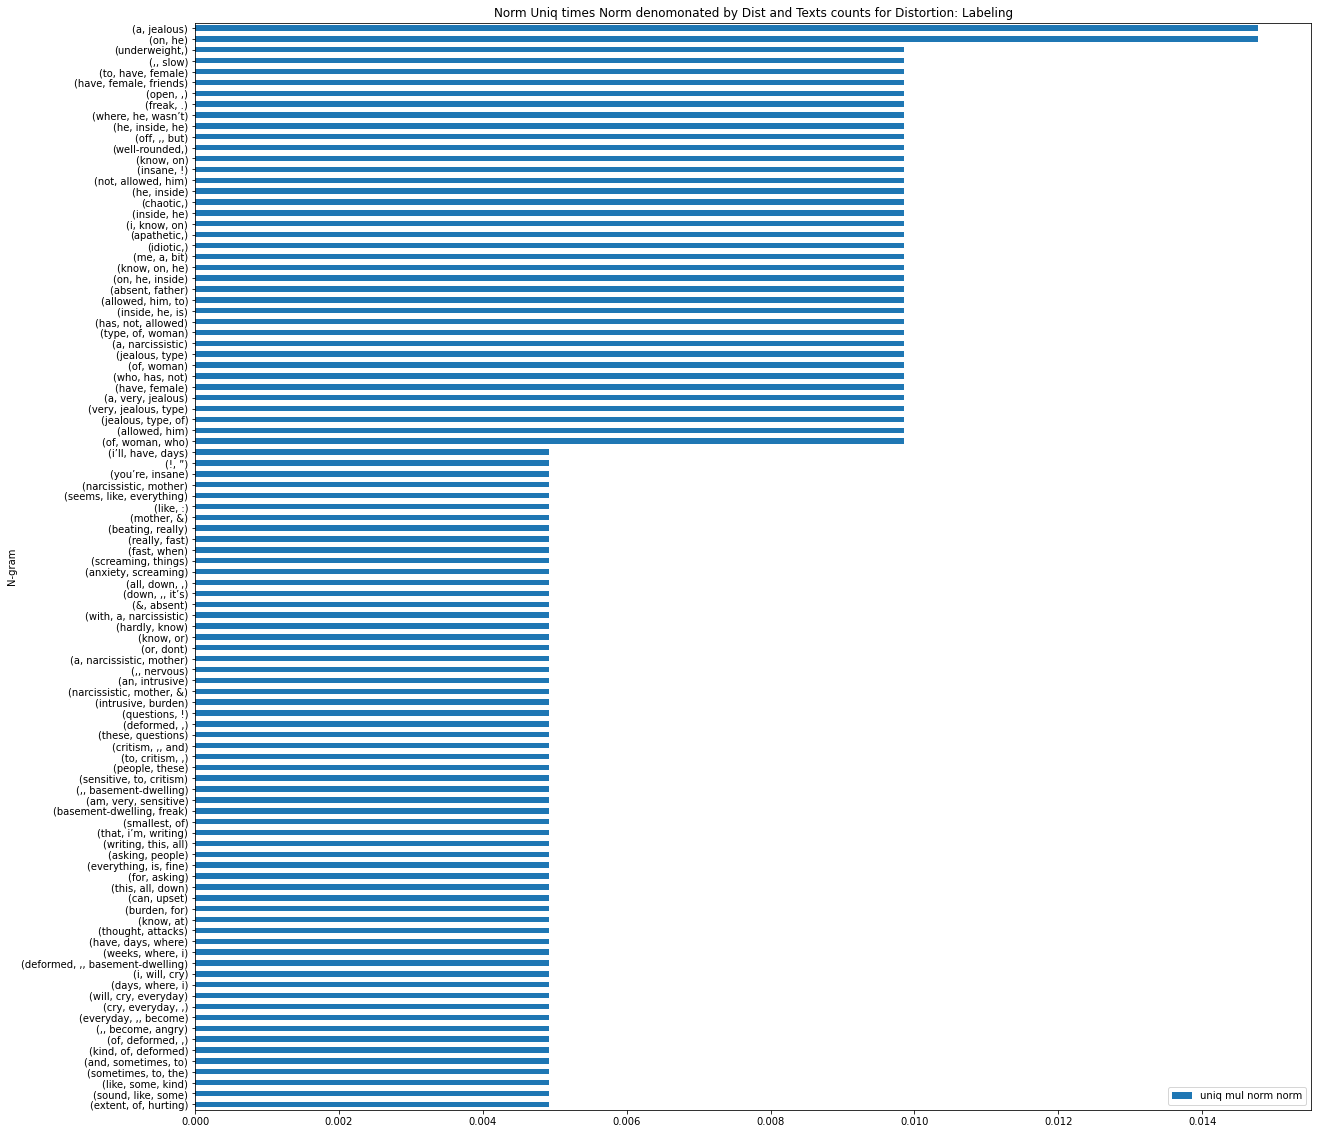

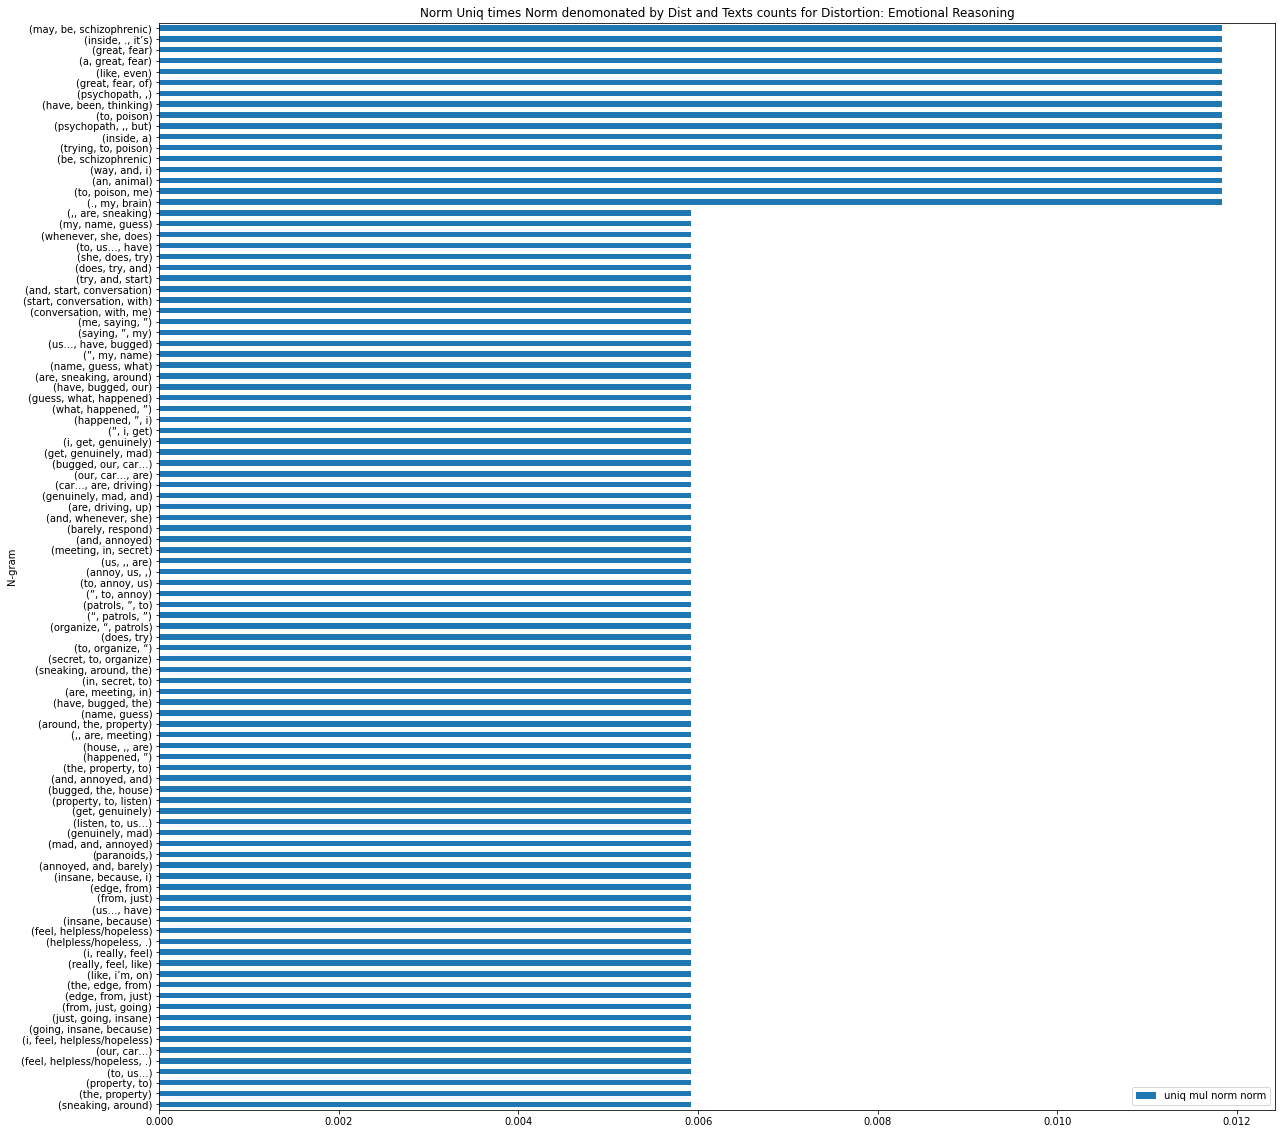

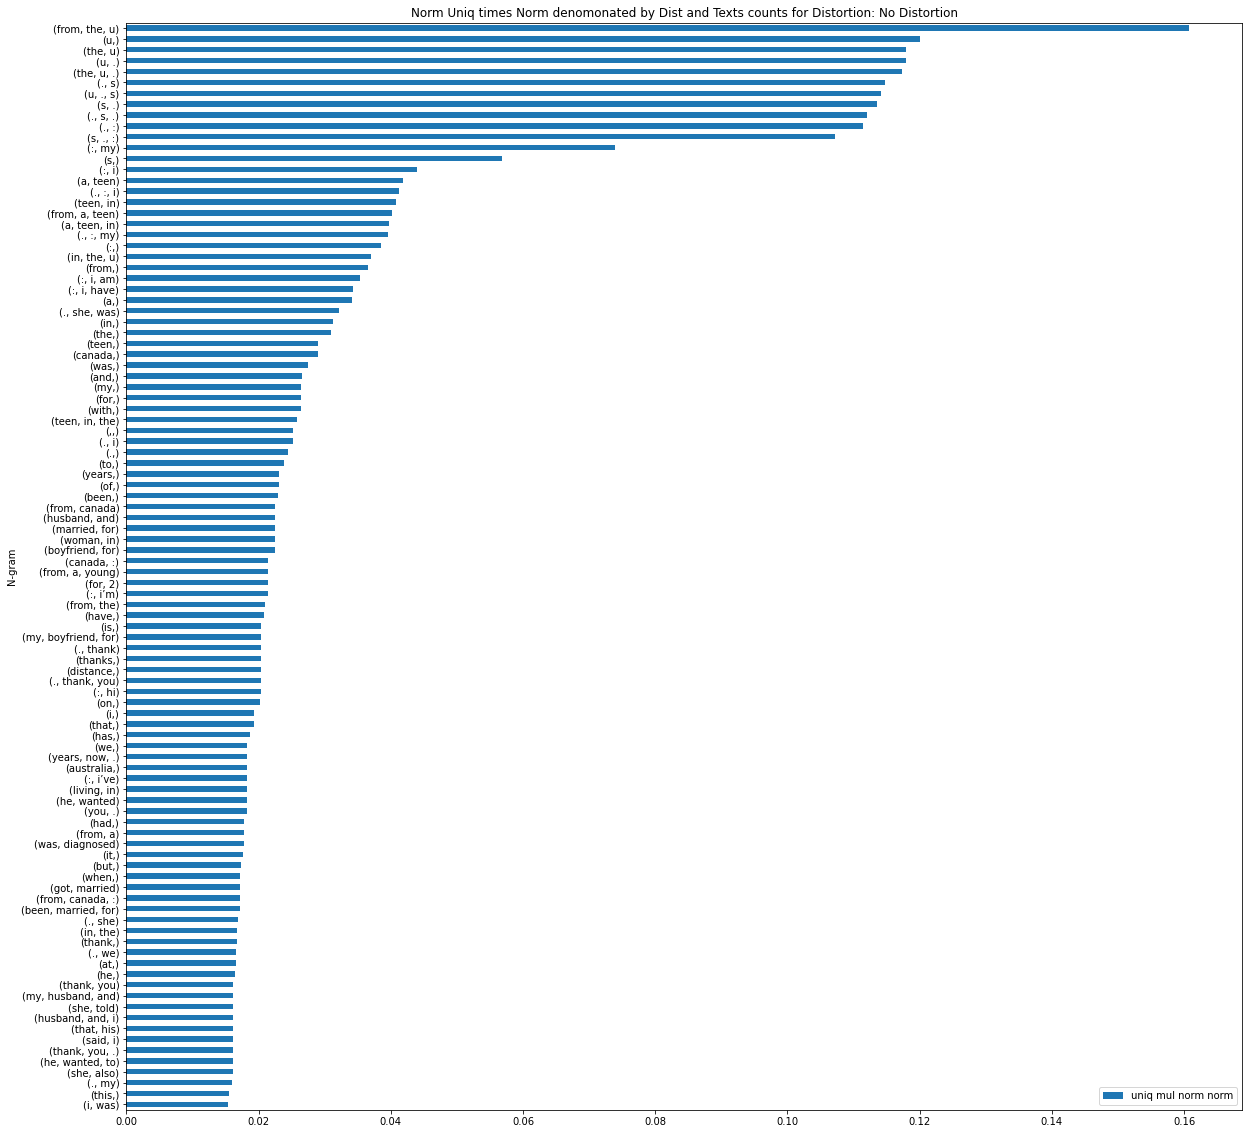

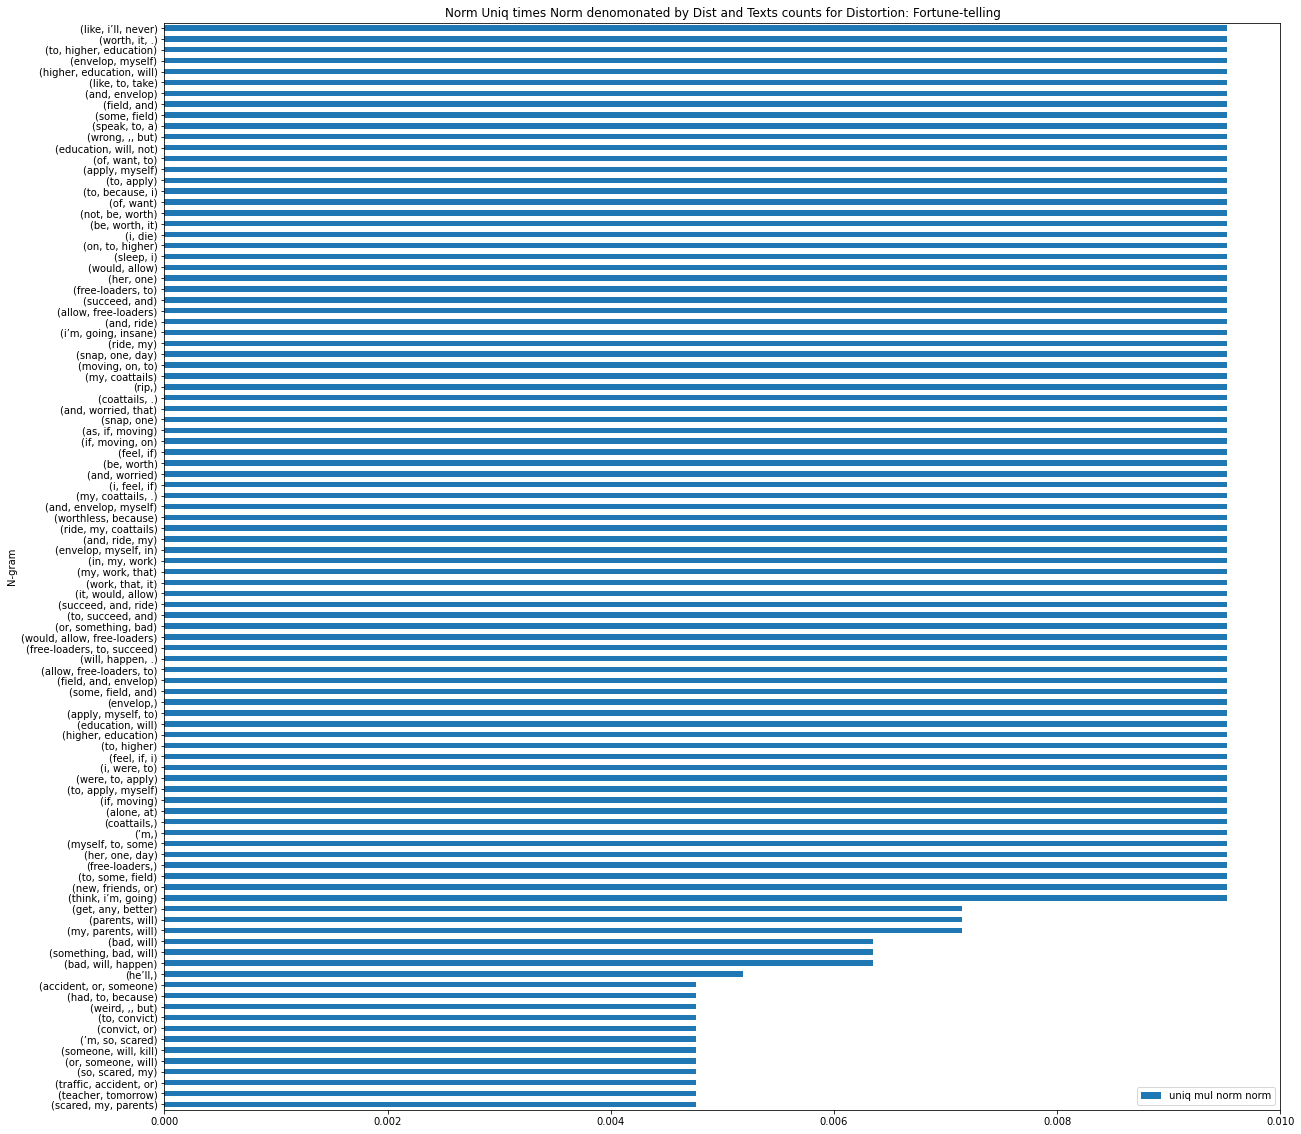

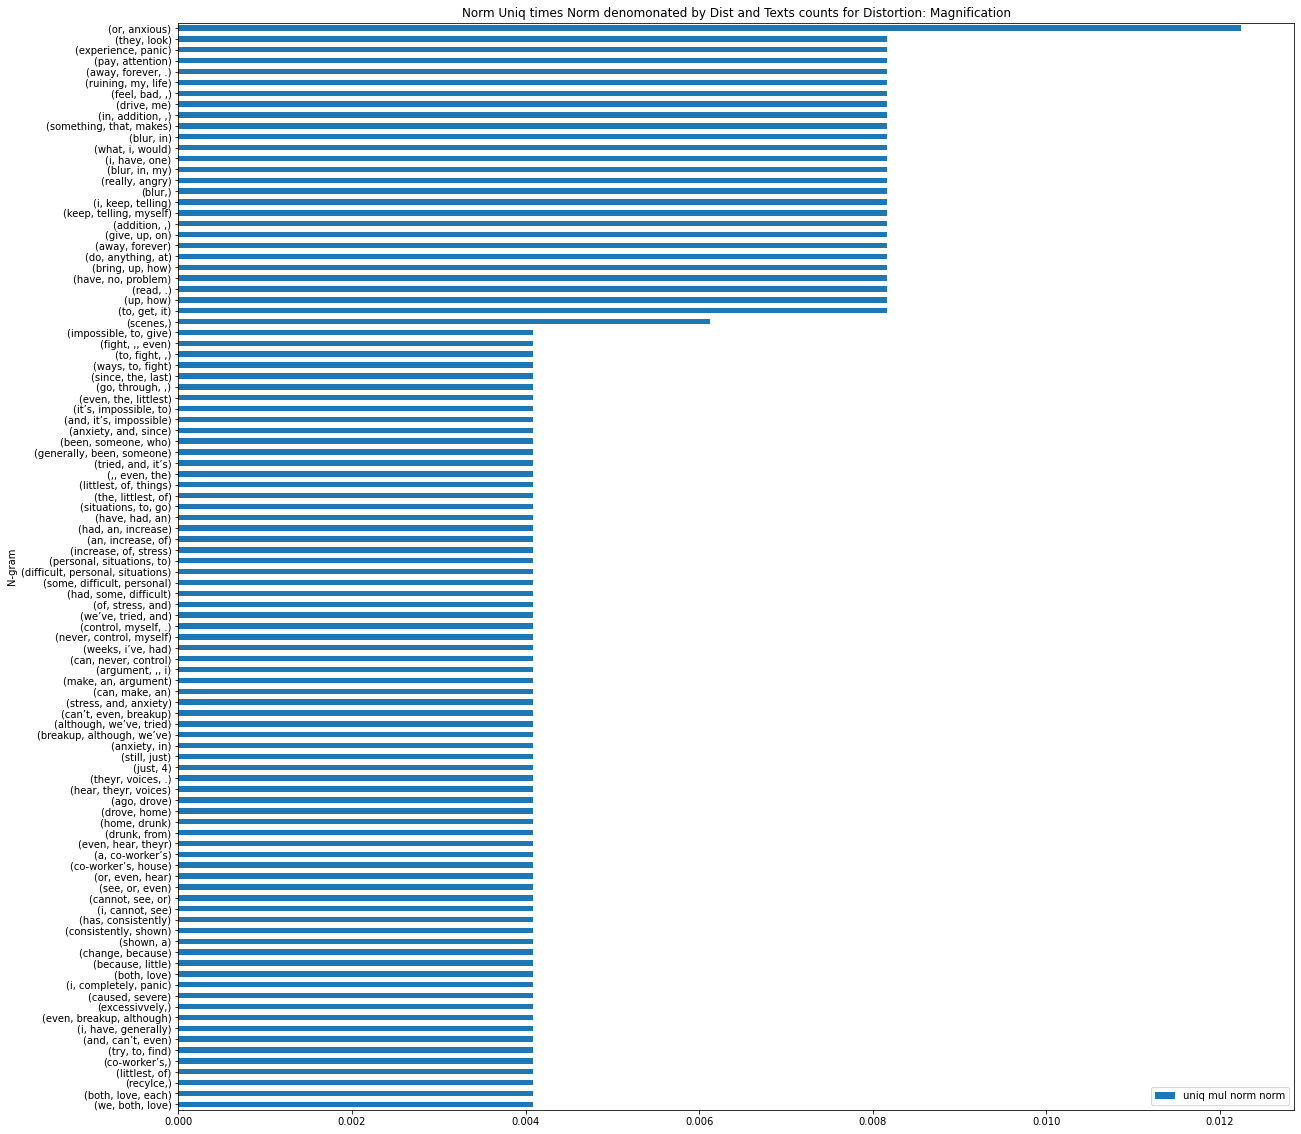

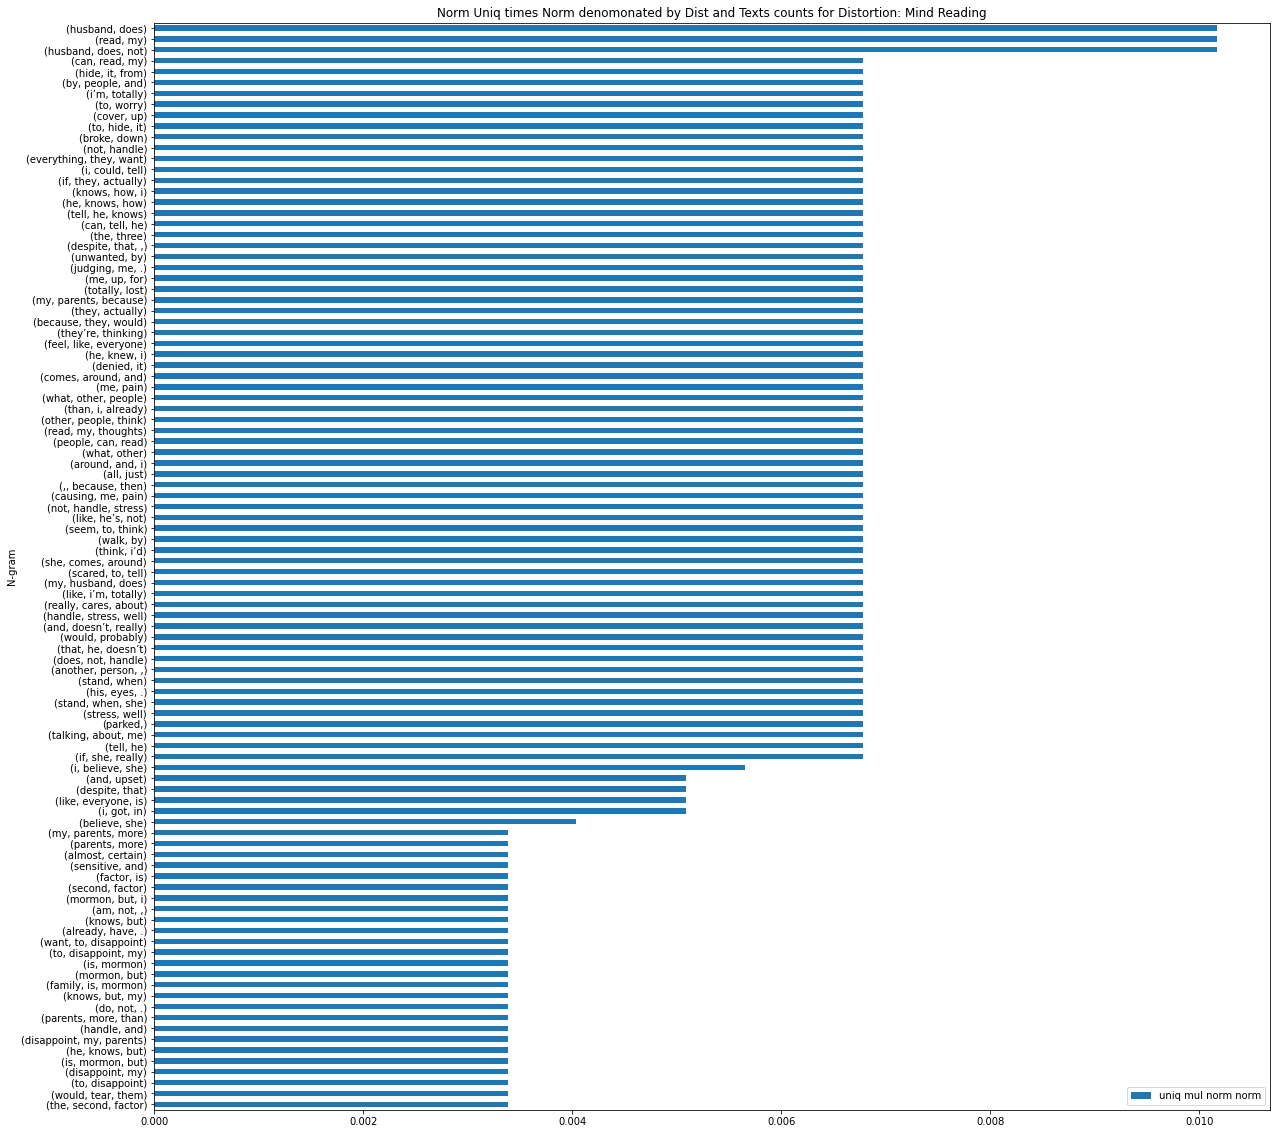

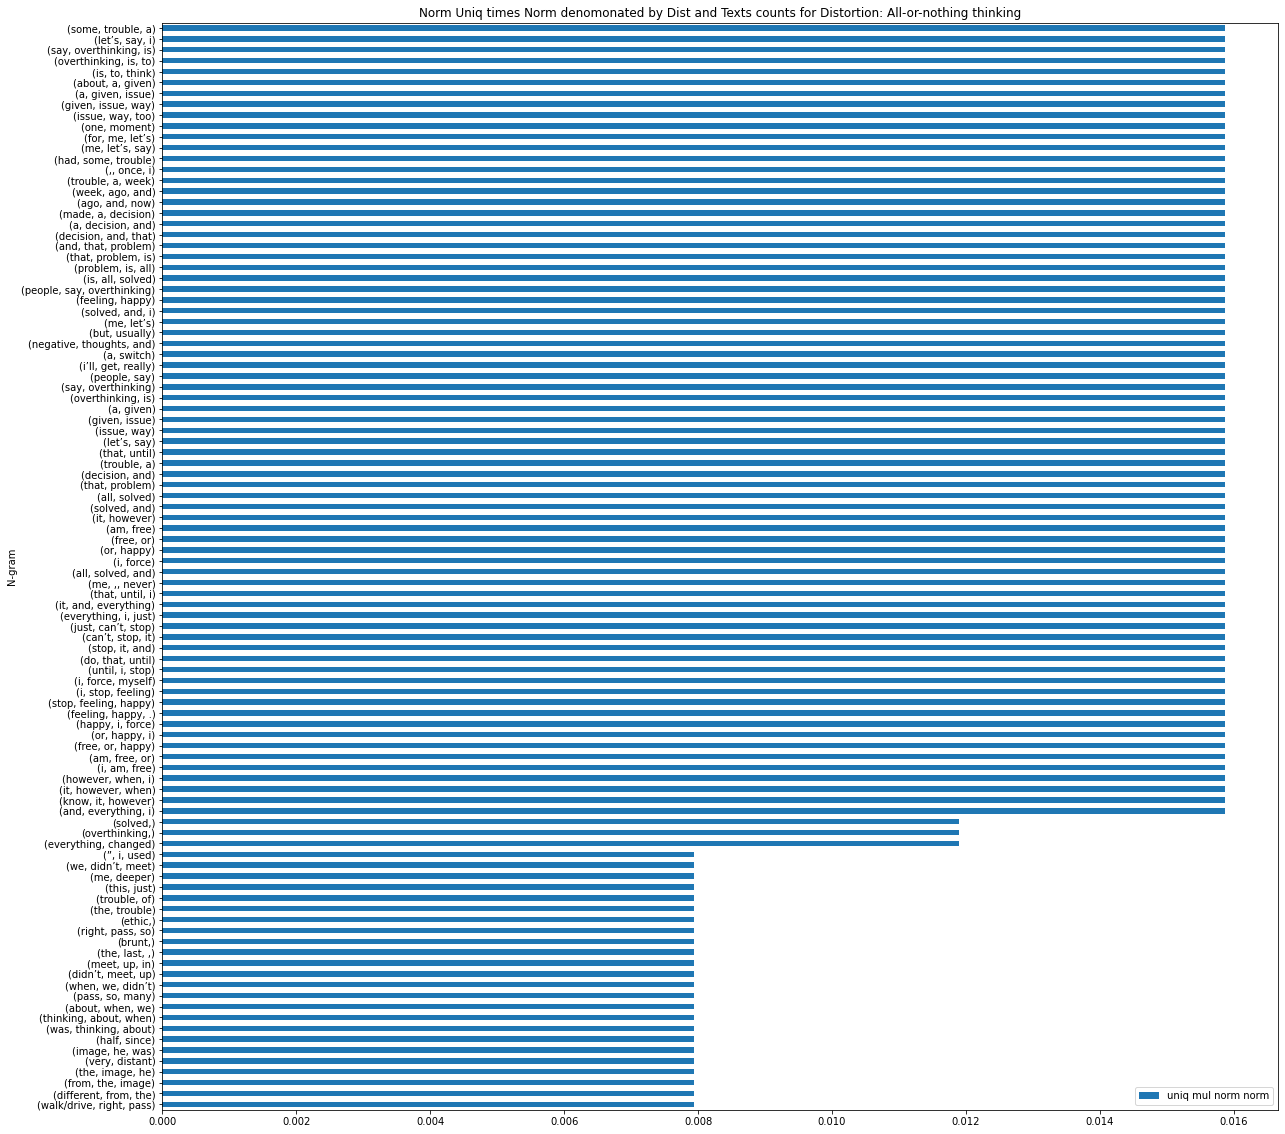

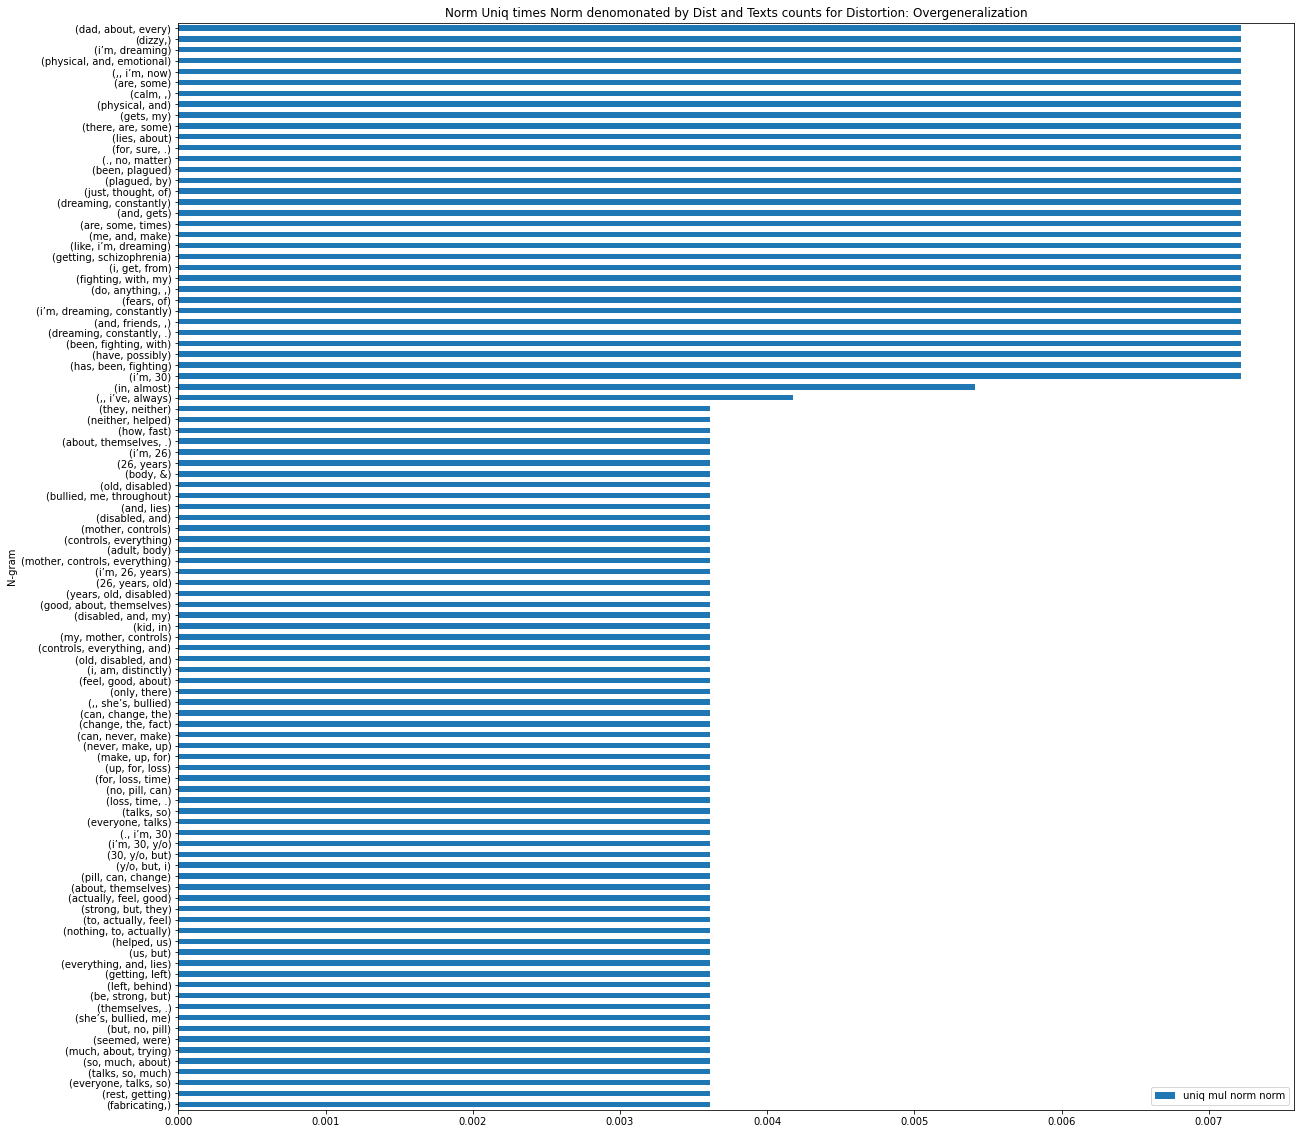

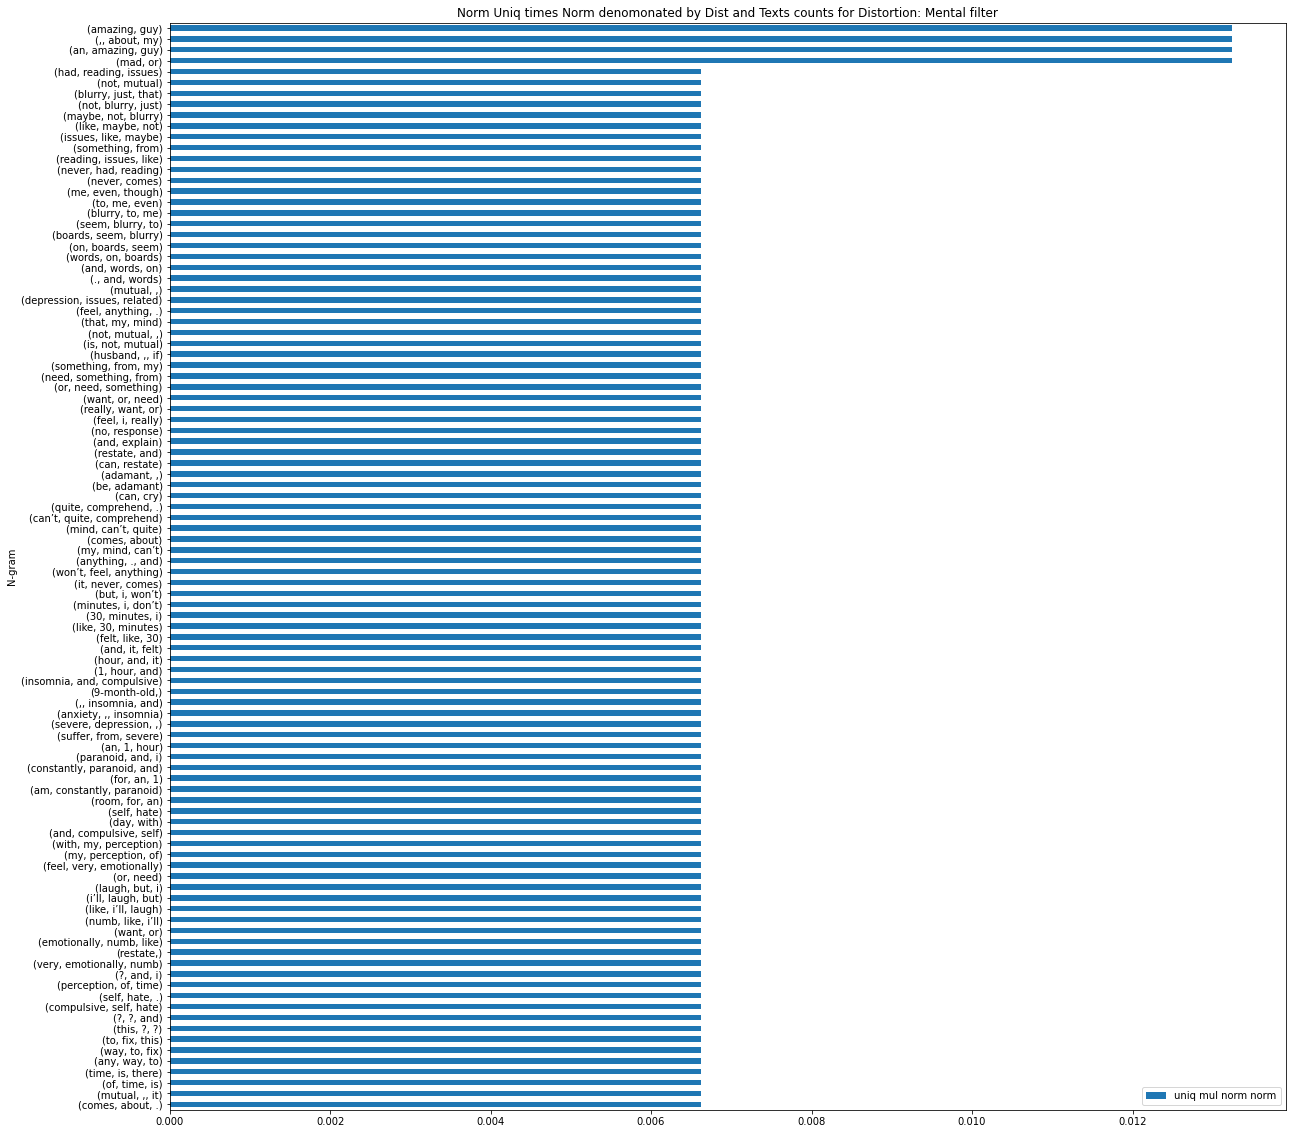

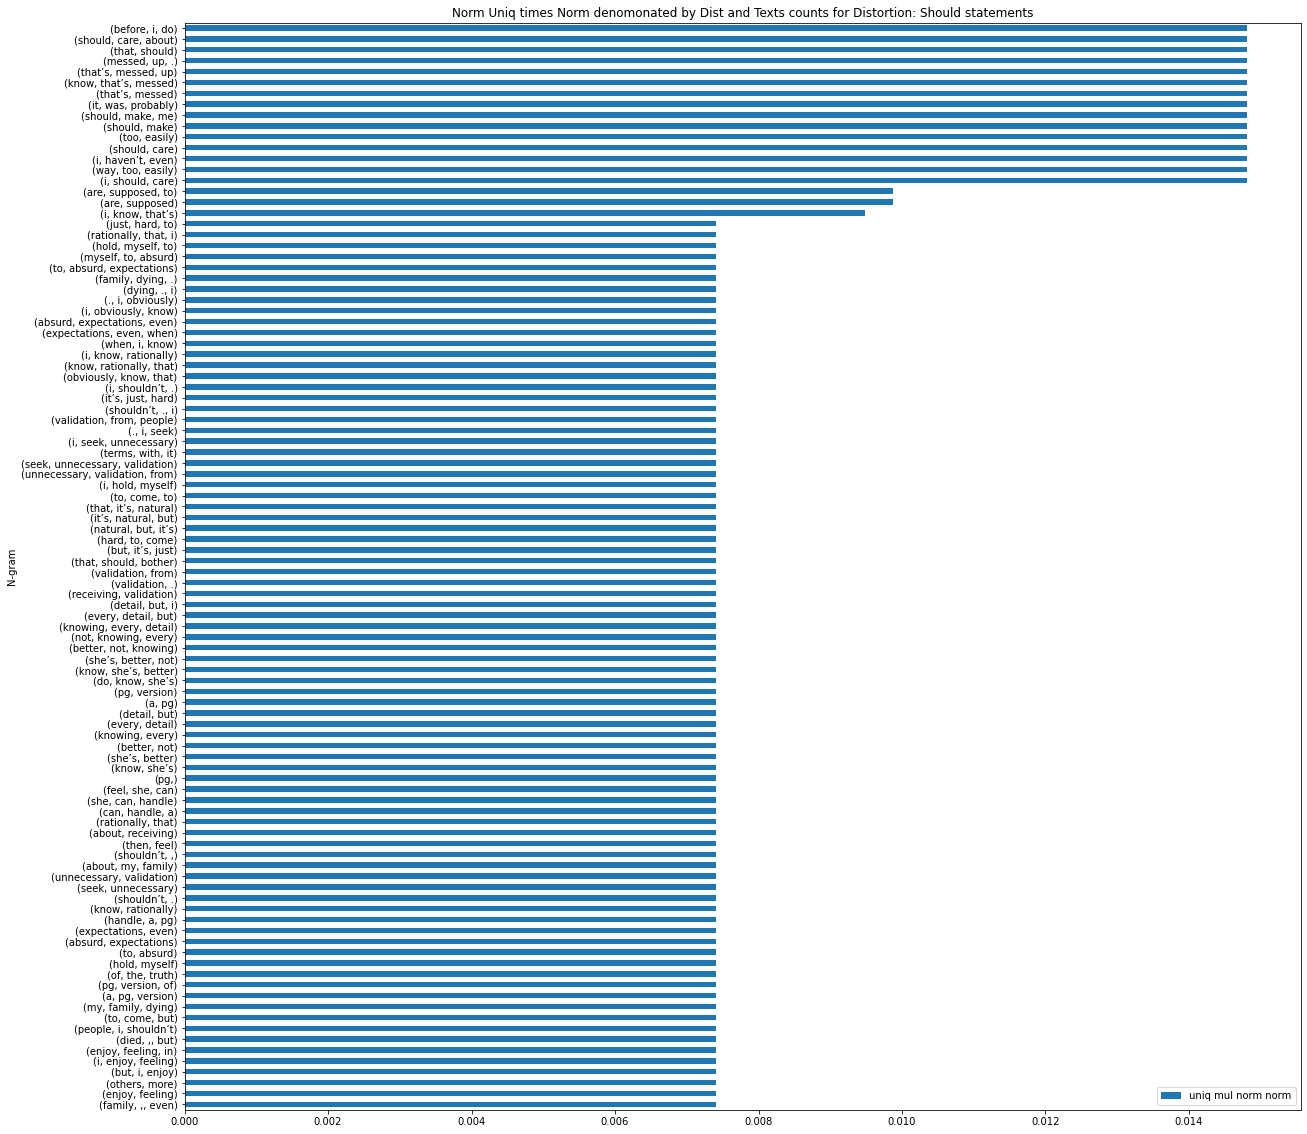

In [20]:
norm = dictdict_div_dict(n_gram_dicts,all_n_grams)
norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)
norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)
norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)

norm_norm_uniq_norm_norm = {} # looks like desired magic
for dist in distortions:
    if not dist in norm_norm_uniq_norm: #hack
        continue
    dic = norm_norm_uniq_norm[dist]
    norm_norm_uniq_norm_norm[dist] = {}
    for n_gram in dic:
        norm_norm_uniq_norm_norm[dist][n_gram] = dic[n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]
"""
for distortion, ngram_dict in norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="norm",head=50,title=f"Norm counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq norm",head=50,title=f"Norm Uniq counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_norm_uniq.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm",head=50,title=f"Norm Uniq times Norm counts for Distortion: {distortion}")
for distortion, ngram_dict in norm_norm_uniq_norm.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm norm",head=100,title=f"Norm Uniq times Norm counts by Dist counts for Distortion: {distortion}")
"""
for distortion, ngram_dict in norm_norm_uniq_norm_norm.items():
    plot_dict(ngram_dict,labels="N-gram",values="uniq mul norm norm",head=100,title=f"Norm Uniq times Norm denomonated by Dist and Texts counts for Distortion: {distortion}")
